# Credit Scorecard Model Notebook
- Author: Marcellinus Aditya Witarsah
- Date: 27 May 2024

This part all of the calculation will be done manually without helper library OptBinning

In [3]:
# Imports
%load_ext autoreload
%autoreload 2
%matplotlib inline
# Data Manipulation

import pandas as pd
import numpy as np

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns


# Scorecard Modelling:
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.calibration import calibration_curve
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score

# Extras:
import pickle
from scipy import stats
from typing import Tuple
from typing import Union

pd.set_option('display.max_colwidth', None)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# About the Data
Table information about the dataset from [Kaggle](https://www.kaggle.com/datasets/laotse/credit-risk-dataset).
|      **Feature Name**      |               **Description**               |
|:--------------------------:|:-------------------------------------------:|
| person_age                 | Age                                         |
| person_income              | Annual Income                               |
| person_home_ownership      | Home ownership                              |
| person_emp_length          | Employment length (in years)                |
| loan_intent                | Loan intent                                 |
| loan_grade                 | Loan grade                                  |
| loan_amnt                  | Loan amount                                 |
| loan_int_rate              | Interest rate                               |
| loan_status                | Loan status (0 is non default 1 is default) |
| loan_percent_income        | Percent income                              |
| cb_person_default_on_file  | Historical default                          |
| cb_preson_cred_hist_length | Credit history length                       |

# Data Load

In [4]:
# Load and inspect data
df = pd.read_csv("../data/raw/credit_risk_dataset.csv")
display(df.head())
display(df.info())
display(df.describe())

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  int64  
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           31686 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_grade                  32581 non-null  object 
 6   loan_amnt                   32581 non-null  int64  
 7   loan_int_rate               29465 non-null  float64
 8   loan_status                 32581 non-null  int64  
 9   loan_percent_income         32581 non-null  float64
 10  cb_person_default_on_file   32581 non-null  object 
 11  cb_person_cred_hist_length  32581 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.0+ MB


None

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length
count,32581.000000,3.258100e+04,31686.000000,32581.000000,29465.000000,32581.000000,32581.000000,32581.000000
mean,27.734600,6.607485e+04,4.789686,9589.371106,11.011695,0.218164,0.170203,5.804211
std,6.348078,6.198312e+04,4.142630,6322.086646,3.240459,0.413006,0.106782,4.055001
min,20.000000,4.000000e+03,0.000000,500.000000,5.420000,0.000000,0.000000,2.000000
25%,23.000000,3.850000e+04,2.000000,5000.000000,7.900000,0.000000,0.090000,3.000000
50%,26.000000,5.500000e+04,4.000000,8000.000000,10.990000,0.000000,0.150000,4.000000
75%,30.000000,7.920000e+04,7.000000,12200.000000,13.470000,0.000000,0.230000,8.000000
max,144.000000,6.000000e+06,123.000000,35000.000000,23.220000,1.000000,0.830000,30.000000


# Exploratory Data Analysis

## Univariate Analysis
Analyzing predictor variable one by one.

### How is the proportion of the response variable?

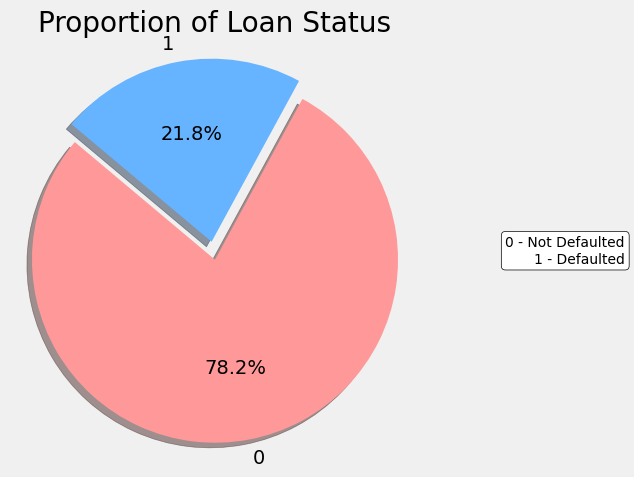

In [5]:
plt.style.use('fivethirtyeight')

# Count the values of "loan_status"
loan_status_counts = df["loan_status"].value_counts()

# Create labels and sizes for the pie chart
labels = ["0", "1"]
sizes = [loan_status_counts[0], loan_status_counts[1]]
colors = ["#ff9999","#66b3ff"]
explode = (0.1, 0)  # explode the 1st slice (Loan Status 0)

# Create the pie chart
fig, ax = plt.subplots(figsize=(8, 5))
ax.pie(sizes, explode=explode, labels=labels, colors=colors, autopct="%1.1f%%", shadow=True, startangle=140)
ax.axis("equal")  # Equal aspect ratio ensures that pie is drawn as a circle.

# Add a title
plt.title("Proportion of Loan Status")

# Add annotation
annotation = (
    "0 - Not Defaulted\n"
    "1 - Defaulted"
)
plt.annotate(annotation, xy=(1, 0.5), xytext=(1.5, 0.5),
    textcoords="axes fraction", ha="right", va="center", fontsize=10,
    bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white")
)

# Show the plot
plt.tight_layout()
# plt.savefig("../reports/figures/proportion_of_loan_status.png")
plt.show()

#### Answer
The response variable is unbalanced, with Good Customers (0) making up approximately **78.2%** and Bad Customers (1) making up about **21.8%**. This imbalance is common in the credit industry, as most users are not expected to default.

### Were there missing values inside the predictor variables?

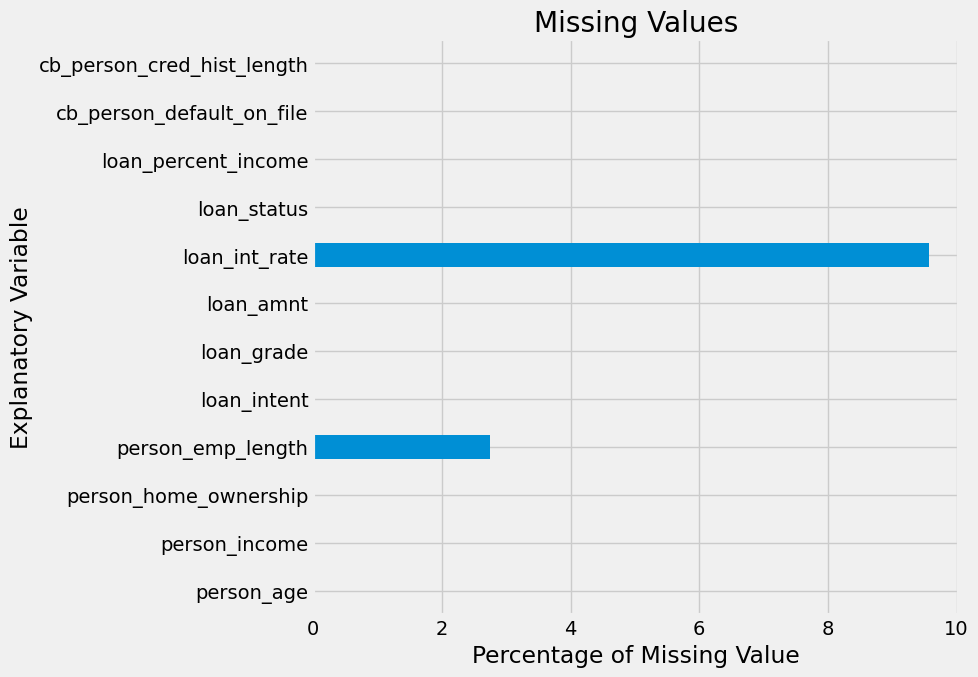

In [6]:
# Count percentage missing values
missing_values_count = df.isna().sum()
(missing_values_count / len(df) * 100).plot(kind="barh", figsize=(10, 7))
plt.title("Missing Values")
plt.xlabel("Percentage of Missing Value")
plt.ylabel("Explanatory Variable")
plt.tight_layout()
# plt.savefig("../reports/figures/missing_values.png")
plt.show()

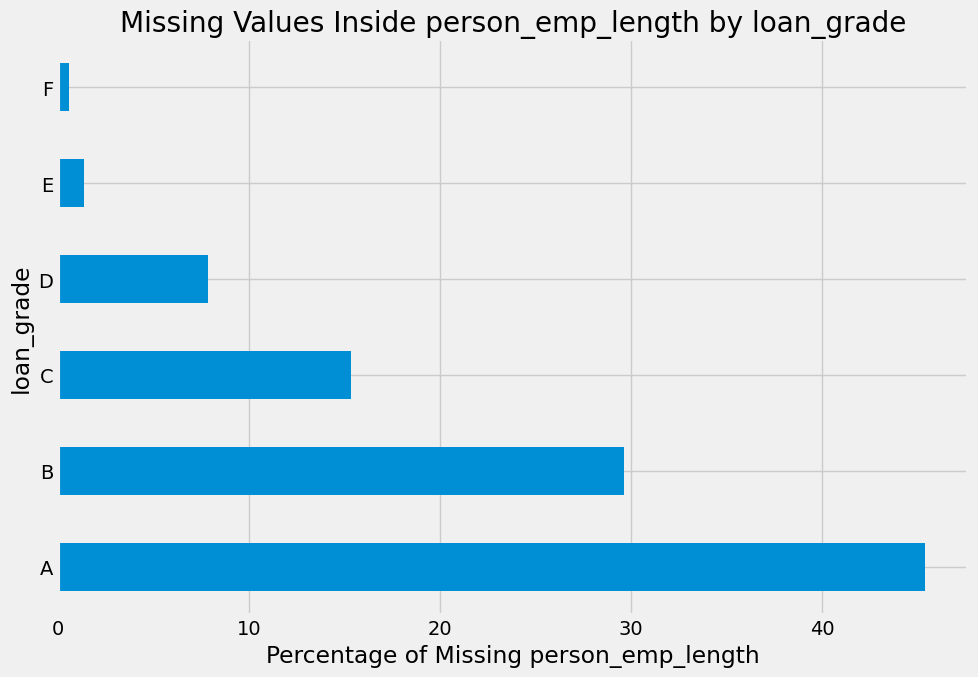

In [8]:
(df[df['person_emp_length'].isna()]['loan_grade'].value_counts(normalize=True)*100).plot(kind="barh", figsize=(10, 7))
plt.title("Missing Values Inside person_emp_length by loan_grade")
plt.xlabel("Percentage of Missing person_emp_length")
plt.ylabel("loan_grade")
plt.tight_layout()
# plt.savefig("../reports/figures/missing_values_inside_person_emp_length_by_loan_grade.png")
plt.show()

In [8]:
df[df['loan_int_rate'].isna()]

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
39,23,71500,RENT,3.0,DEBTCONSOLIDATION,D,30000,NaN,1,0.42,N,4
50,24,78000,RENT,4.0,DEBTCONSOLIDATION,D,30000,NaN,1,0.38,Y,4
57,23,277000,OWN,3.0,PERSONAL,A,35000,NaN,0,0.13,N,4
59,24,12000,OWN,2.0,VENTURE,E,1750,NaN,0,0.15,Y,3
62,26,263000,MORTGAGE,0.0,EDUCATION,B,10000,NaN,1,0.04,N,4
...,...,...,...,...,...,...,...,...,...,...,...,...
32547,53,4888,OWN,0.0,VENTURE,C,1400,NaN,1,0.29,Y,28
32552,65,45900,RENT,2.0,EDUCATION,C,10000,NaN,0,0.22,Y,19
32553,54,20000,RENT,2.0,MEDICAL,C,5000,NaN,0,0.25,N,28
32569,51,60000,MORTGAGE,1.0,PERSONAL,A,7500,NaN,0,0.13,N,23


#### Answer
There are missing values in the `person_emp_length` and `loan_int_rate` variables.
1. Missing values in `person_emp_length` may indicate unemployment or self-employment. To address this, they are filled with 0 values. Further analysis revealed that most applicants with missing `person_emp_length` have high loan_grade, with approximately 75% falling into grades A and B. This suggests they could be either **business owners or unemployed with alternative income sources**.
2. Missing values in `loan_int_rate` may result from human or system errors. Further investigation is needed to determine the cause. **For this project, missing values are replaced with the mean or median, based on the data distribution**.


### How is the distribution for the numerical predictor variable? Are there any outliers or anomalies?

In [9]:
def plot_hist_box(df: pd.DataFrame, numerical_predictor_variable: str,figsize: Tuple[int, int]) -> None:
    """
    Show distribution of numerical data by histogram plot and boxplot.
    
    Parameters
    ------------
        df (pd.DataFrame): The dataframe containing the data.
        numerical_predictor_variable (str): numerical columns to be plotted
        figsize (Tuple[int, int]): size of the plot.
    Returns
    ------------
        None
    """
    _, ax = plt.subplots(1, 2, figsize=figsize)  # Create a figure with 1 row and 2 columns

    # Histogram
    df[numerical_predictor_variable].hist(ax=ax[0], bins=30, edgecolor='black')
    mean_value = df[numerical_predictor_variable].mean()
    median_value = df[numerical_predictor_variable].median()
    ax[0].axvline(mean_value, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean_value:.2f}')
    ax[0].axvline(median_value, color='blue', linestyle='dashed', linewidth=2, label=f'Median: {median_value:.2f}')
    ax[0].set_title(f"Histogram of {numerical_predictor_variable}")
    ax[0].set_xlabel(numerical_predictor_variable)
    ax[0].set_ylabel("Frequency")
    ax[0].legend()

    # Boxplot
    df.boxplot(column=numerical_predictor_variable, ax=ax[1])
    ax[1].set_title(f"Boxplot of {numerical_predictor_variable}")
    ax[1].set_xlabel(numerical_predictor_variable)
    ax[1].set_ylabel("Value")

    # Show plots
    plt.tight_layout()
    # plt.savefig(f"../reports/figures/histogram_boxplot_of_{numerical_predictor_variable}.png")
    plt.show()

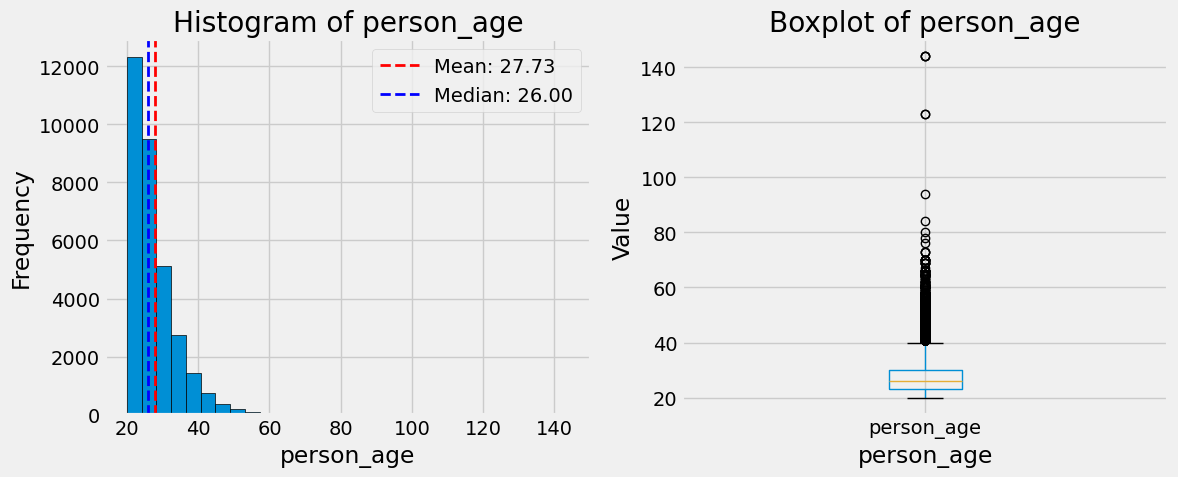

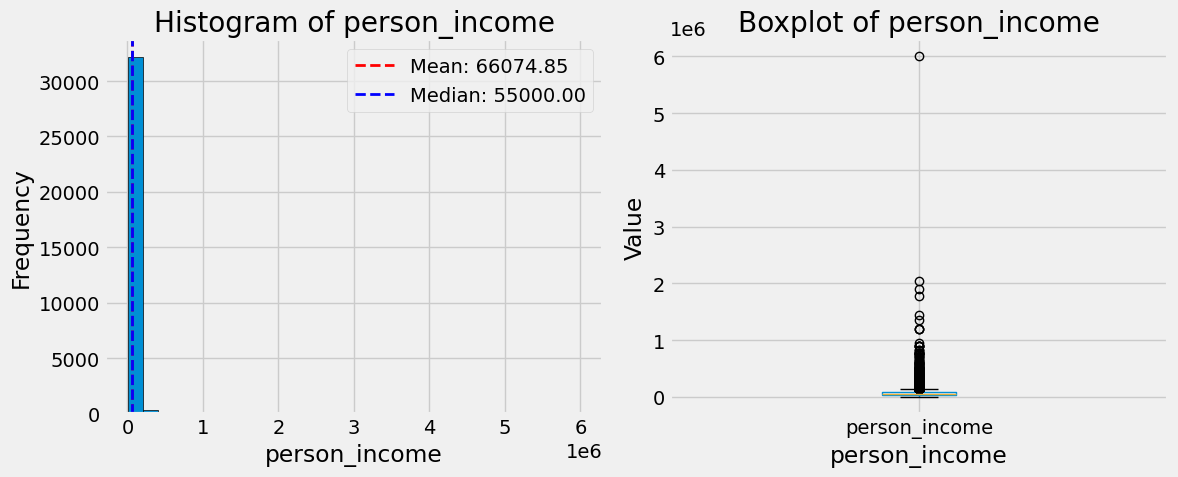

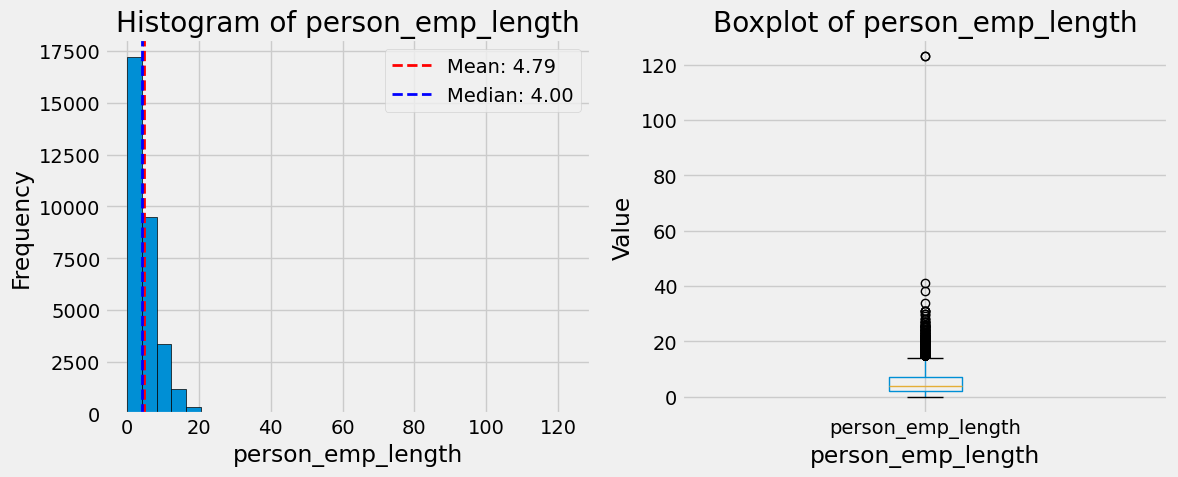

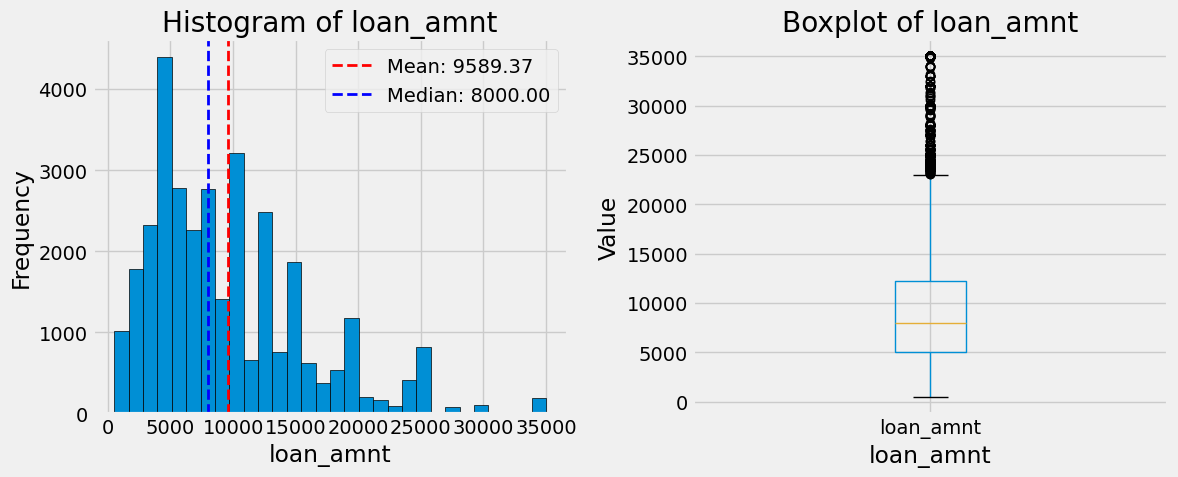

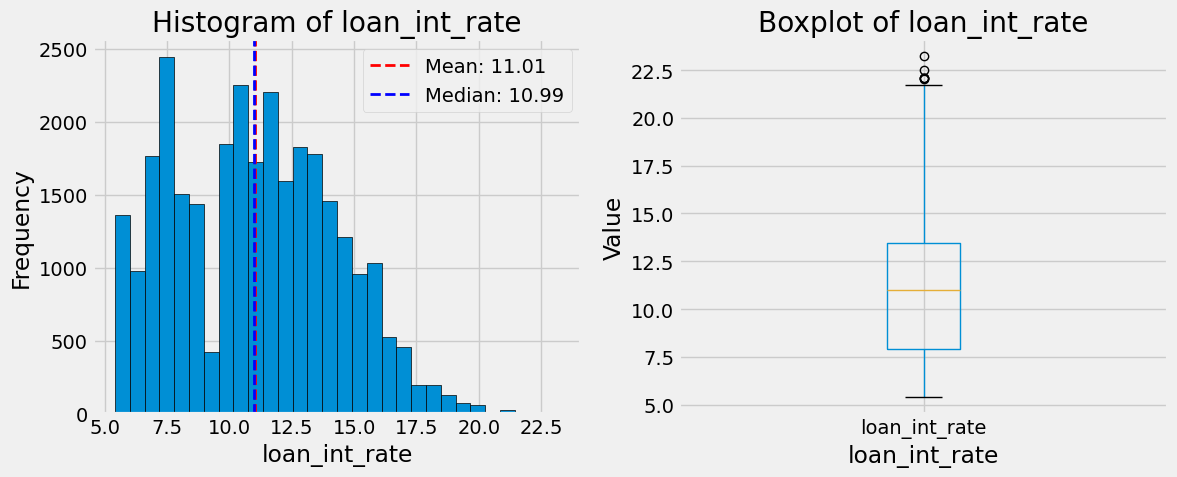

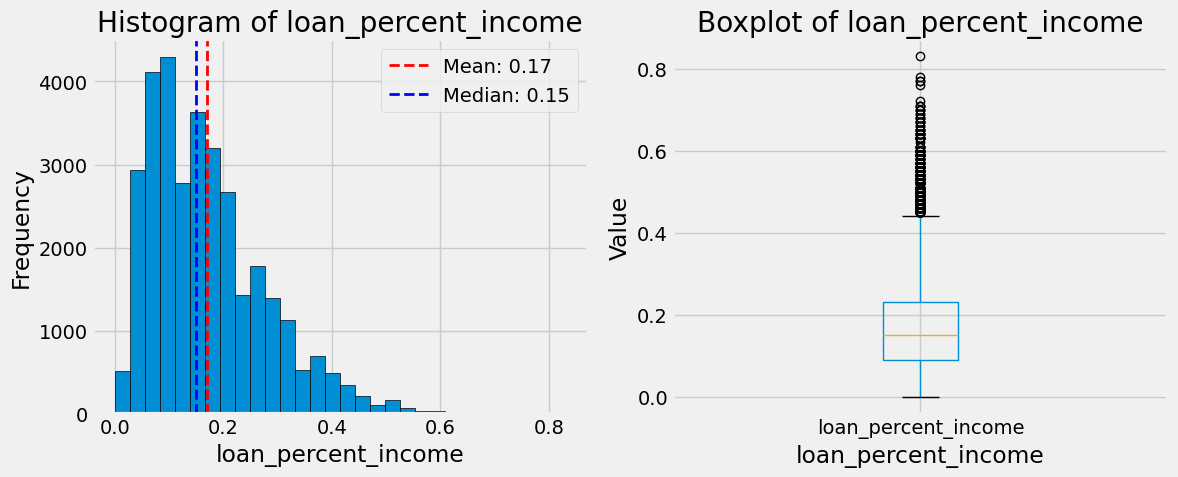

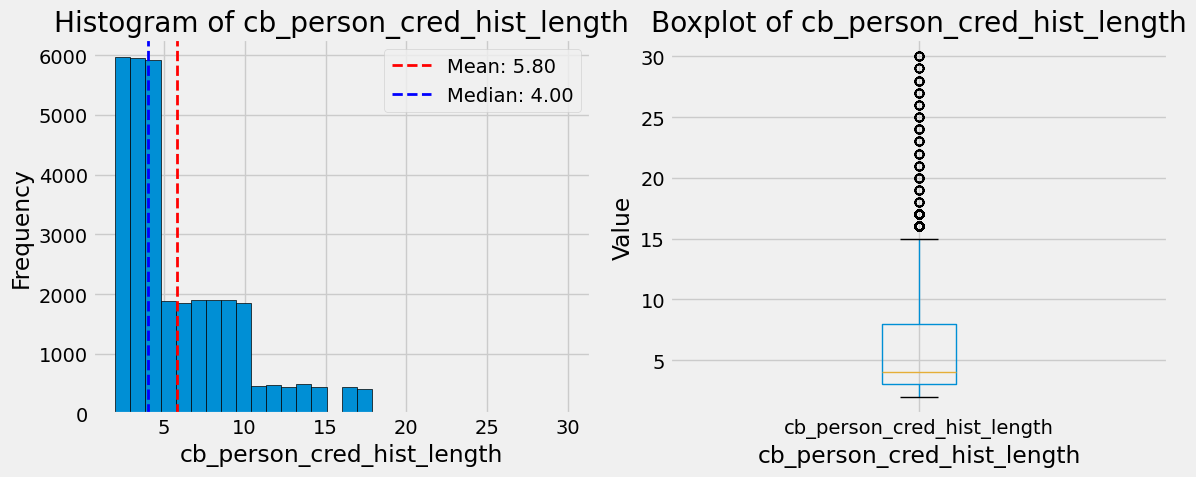

In [10]:
# Plot histogram and boxplot
plt.style.use('fivethirtyeight')
for predictor_variable in df.select_dtypes("number").columns:
    if predictor_variable != "loan_status":
        plot_hist_box(df, predictor_variable, (12, 5))

In [12]:
for predictor_variable in df.select_dtypes("number").columns:
    if predictor_variable != "loan_status":
        print(f"{predictor_variable}: {df[predictor_variable].skew()}")

person_age: 2.5813925261849846
person_income: 32.865348833904434
person_emp_length: 2.6144551214595424
loan_amnt: 1.1924774277661998
loan_int_rate: 0.2085503016908977
loan_percent_income: 1.0646686367683245
cb_person_cred_hist_length: 1.6617901199126253


In [13]:
df[df["person_age"] > 122]

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
81,144,250000,RENT,4.0,VENTURE,C,4800,13.57,0,0.02,N,3
183,144,200000,MORTGAGE,4.0,EDUCATION,B,6000,11.86,0,0.03,N,2
575,123,80004,RENT,2.0,EDUCATION,B,20400,10.25,0,0.25,N,3
747,123,78000,RENT,7.0,VENTURE,B,20000,NaN,0,0.26,N,4
32297,144,6000000,MORTGAGE,12.0,PERSONAL,C,5000,12.73,0,0.00,N,25


Suspected outliers are detected in the `person_age` variable, where the maximum observed age is 122 years old. To address this issue, records with a `person_age` above 122 are removed.

In [14]:
df[df["person_emp_length"] > df["person_age"]]

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
210,21,192000,MORTGAGE,123.0,VENTURE,A,20000,6.54,0,0.10,N,4


Outliers are also present in the `person_emp_length` variable, where values exceed a realistic employment duration, such as 123 years for applicants aged 21 and 22. To address this, we can either remove these records or replace the outliers with the average employment duration for applicants within the same age range.

In [15]:
df[df["cb_person_cred_hist_length"] > df["person_age"]]

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length


Checking if there are loan applications have a credit history way longer than their age.

#### Answer
**Positive outliers are observed in all predictor variables, resulting in right-skewed distributions. Some of these outliers are explainable**:
1. `person_income`: High net worth individuals (HNWIs) contribute to the skewness in income distributions.
2. `loan_amnt`: Borrowers with higher incomes may seek larger loan amounts.
3. `loan_int_rate`: Higher loan interest rates may apply to customers perceived as high-risk.
4. `loan_percent_income`: Some borrowers may request loans closer to their income percentage, potentially due to emergencies.
5. `cb_person_cred_hist_length`: Some individuals have exceptionally long credit histories.

**Anomalies in the data include**:
1. `person_age`: While the oldest recorded individuals lived to 122 years, some entries in the dataset exceed this limit. To address this, records with `person_age` above 122 are removed, as they represent only a small fraction of the dataset (5 records).
2. `person_emp_length`: It's impossible for loan applicants aged 21 and 22 to have worked for 123 years. To rectify this, replace these outlier values with the common employment duration for their age range.

### How is the occurence of categorical predictor variable?

In [11]:
def plot_count_categorical(df: pd.DataFrame, categorical_predictor_variable: str, figsize: Tuple[int, int]) -> None:
    """
    Show number of occurences of each categorical column.
    
    Parameters
    ------------
        df (pd.DataFrame): The dataframe containing the data.
        numerical_column (str): The numerical column to be plotted.
        categorical_predictor_variable (str): categorical columns to be plotted
        figsize (Tuple[int, int]): size of the plot.
    Returns
    ------------
        None
    """
    _, ax = plt.subplots(figsize=figsize)  # Create a figure

    # Bar plot
    df[categorical_predictor_variable].value_counts(normalize=True).plot(kind='barh', ax=ax, edgecolor='black')
    ax.set_title(f"Count of {categorical_predictor_variable}")
    ax.set_xlabel(categorical_predictor_variable)
    ax.set_ylabel("Count")

    # Show plot
    plt.tight_layout()
    # plt.savefig(f"../reports/figures/countplot_of_{categorical_predictor_variable}.png")
    plt.show()

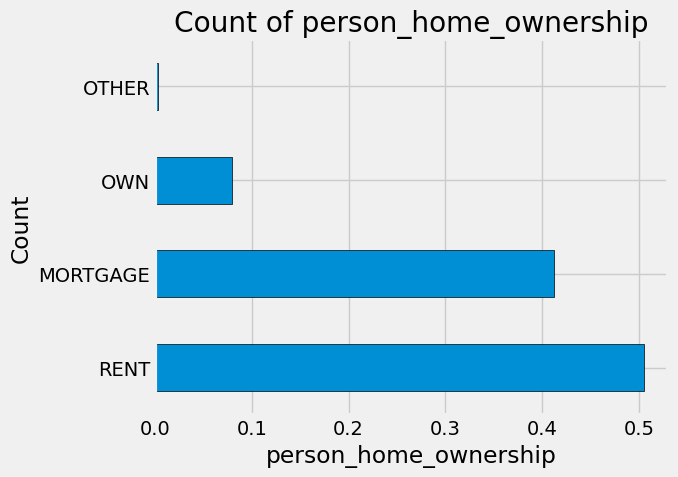

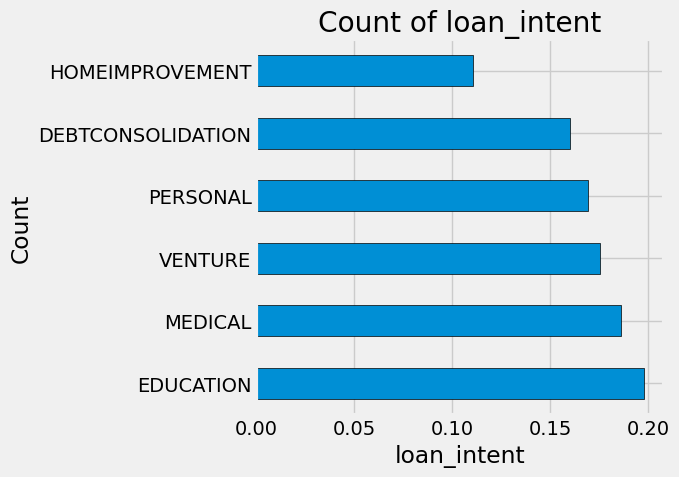

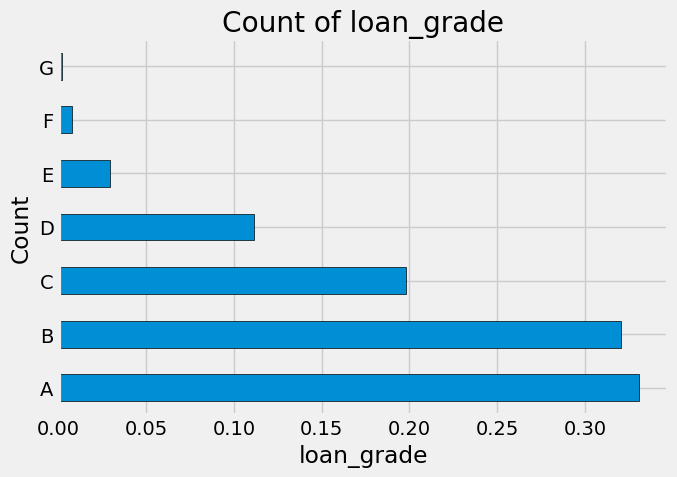

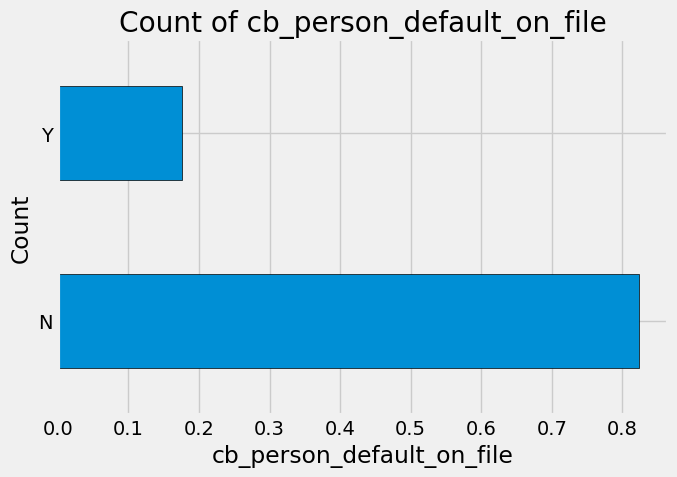

In [12]:
plt.style.use('fivethirtyeight')
for predictor_variable in df.select_dtypes("object").columns:
    plot_count_categorical(df, predictor_variable, (7, 5))

#### Answer
The occurences of:
1. `person_home_ownership` around 90% of loan applications still don't own a property or home where 50% of them is still renting and 40% of them still on mortgage.
2. `loan_intent` are almost distributed evenly around each category.
3. `loan_grade` around 65% of the loan applicants has a good loan grade, A and B.
4. `cb_person_default_on_file` almost 20% of the customers had history of credit default. 

## Multivariate Analysis

### What is the distribution of the numerical predictor variable across different classes of the response target variable?

In [13]:
def plot_dist_numerical_by_target(df: pd.DataFrame, numerical_predictor_variable: str, response_variable: str, figsize: Tuple[int, int]) -> None:
    """
    Show distribution and boxplot of a numerical column, grouped by a target column.
    
    Parameters
    ------------
        df (pd.DataFrame): The dataframe containing the data.
        numerical_predictor_variable (str): The numerical column to be plotted.
        response_variable (str): The target column for grouping.
        figsize (Tuple[int, int]): size of the plot.
    Returns
    ------------
        None
    """
    _, axes = plt.subplots(1, 2, figsize=figsize)  # Create a figure with 1 row and 2 columns

    # KDE plot with hue
    for target_value in df[response_variable].unique():
        sns.kdeplot(data=df[df[response_variable]==target_value], x=numerical_predictor_variable, ax=axes[0], label=target_value)
    axes[0].set_title(f"Distribution of {numerical_predictor_variable}")
    axes[0].set_xlabel(numerical_predictor_variable)
    axes[0].set_ylabel("Density")
    axes[0].legend(title=response_variable)

    # Boxplot with hue
    sns.boxplot(x=response_variable, y=numerical_predictor_variable, data=df, hue=response_variable, ax=axes[1])
    axes[1].set_title(f"Boxplot of {numerical_predictor_variable}")
    axes[1].set_xlabel(response_variable)
    axes[1].set_ylabel(numerical_predictor_variable)

    # Show plots
    plt.tight_layout()
    # plt.savefig(f"../reports/figures/histogram_{numerical_predictor_variable}_vs_{response_variable}.png")
    plt.show()


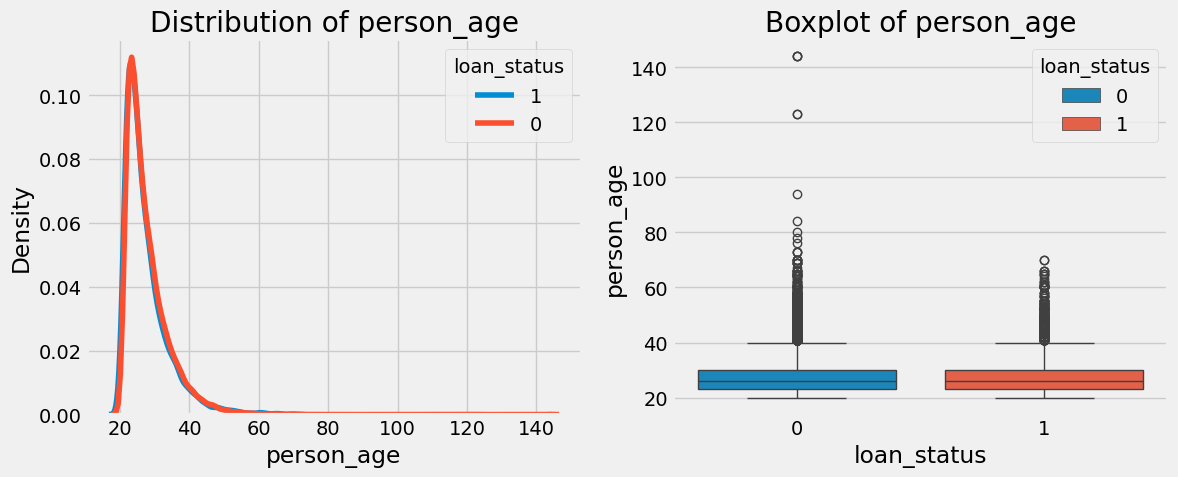

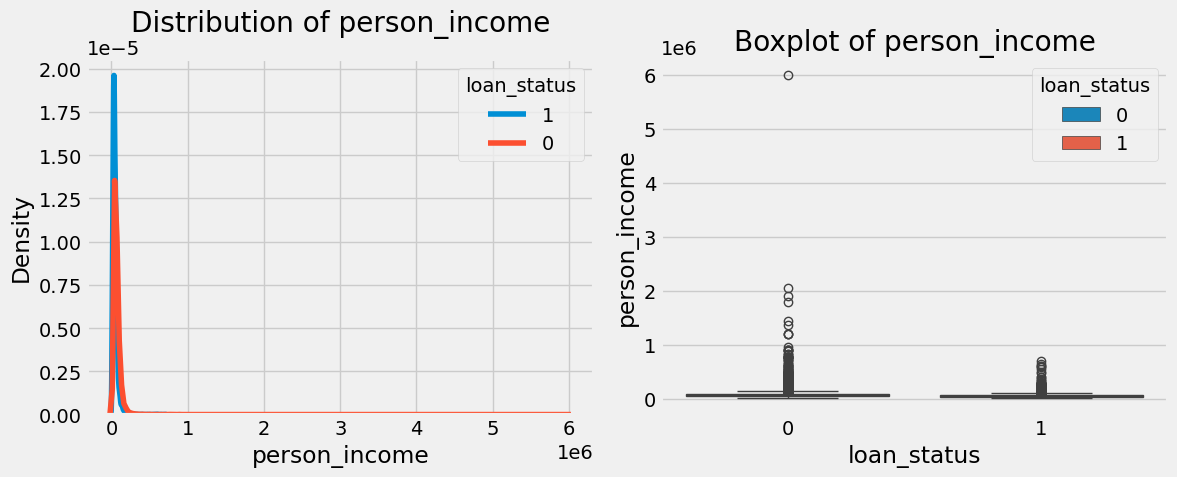

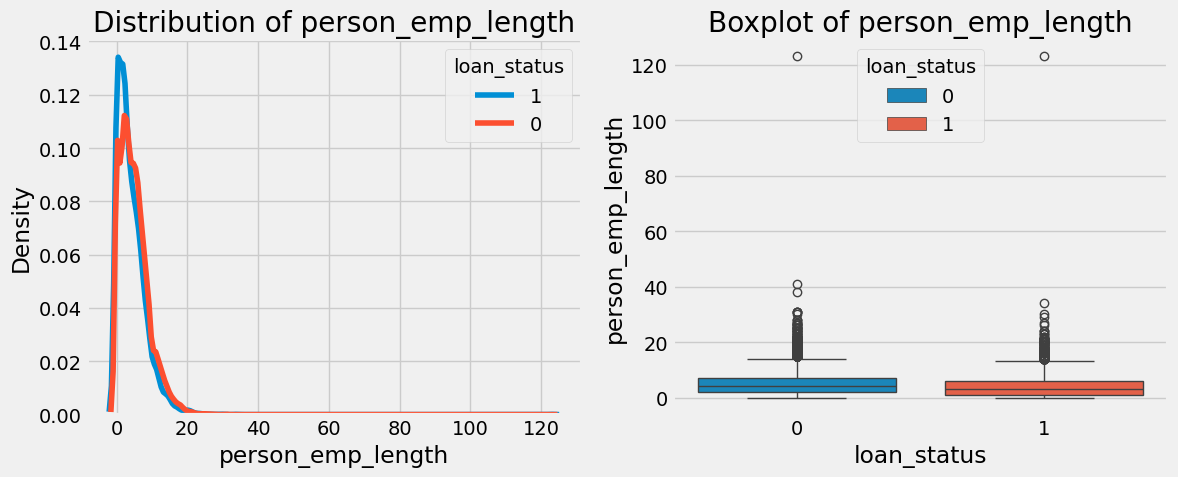

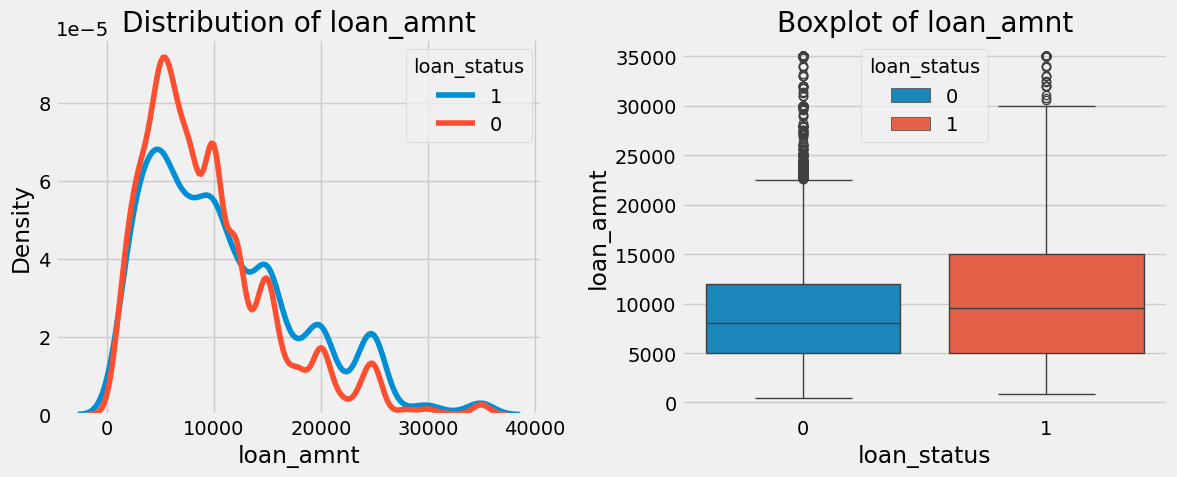

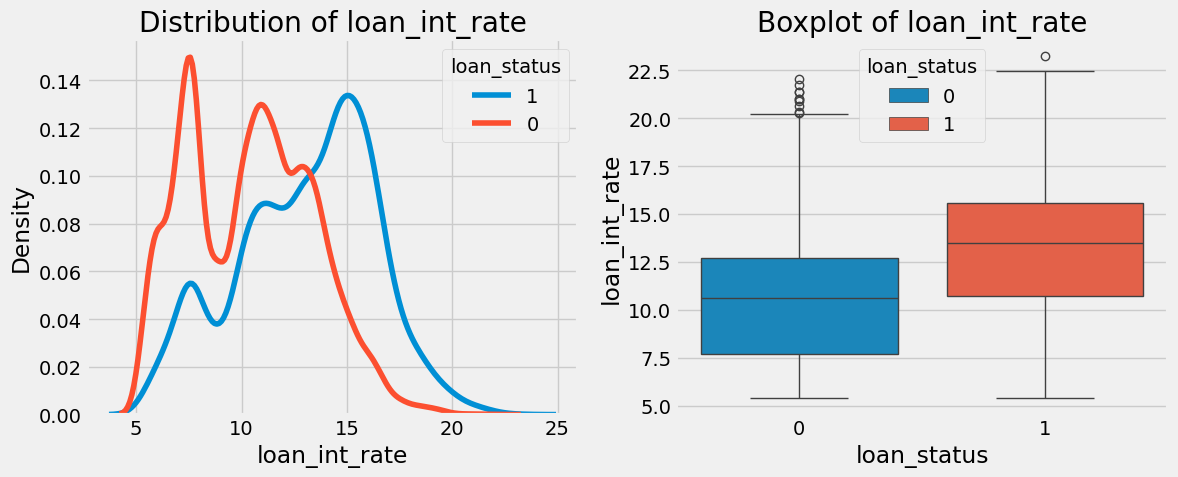

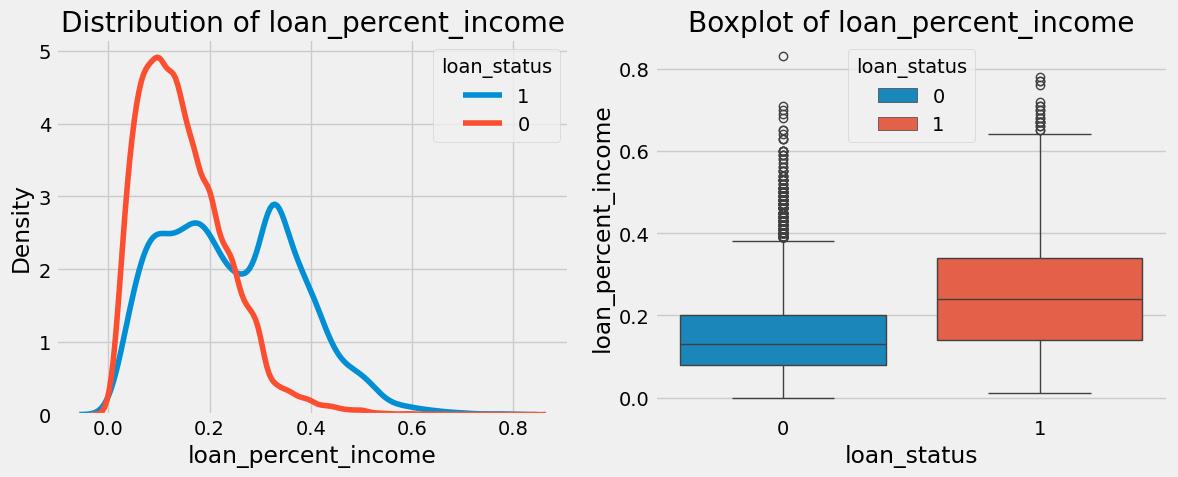

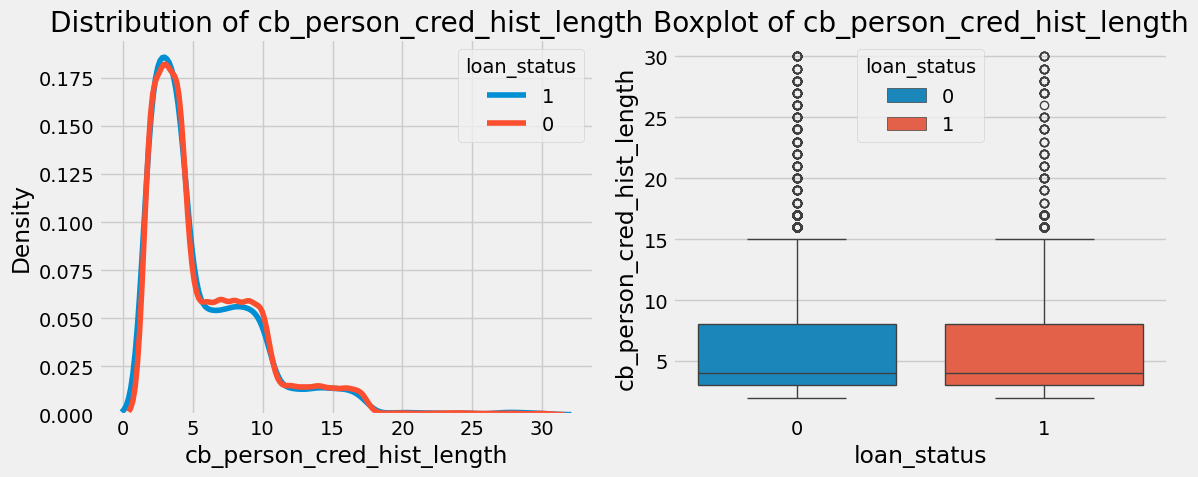

In [14]:
for predictor_variable in df.select_dtypes("number").columns:
    if predictor_variable != "loan_status":
        plot_dist_numerical_by_target(df, predictor_variable, "loan_status", (12, 5))

#### Answer
Distributions of `loan_int_rate` and `loan_percent_income` vary based on the response variable, suggesting that higher values of these features correlate with a higher likelihood of default.

### Do certain categories of the categorical predictor variable have higher or lower probabilities of a specific class in the response variable?

In [16]:
def plot_probability_response_by_categorical(df: pd.DataFrame, categorical_predictor_variable: str, response_variable: str, figsize: Tuple[int, int]) -> None:
    '''
    Show count of values inside categorical column, grouped by a response column.
    
    Parameters
    ------------
        df (pd.DataFrame): The dataframe containing the data.
        categorical_predictor_variable (str): The categorical column to be plotted.
        response_variable (str): The response column for grouping.
        figsize (Tuple[int, int]): size of the plot.
    Returns
    ------------
        None
    '''
    fig, ax = plt.subplots(figsize=figsize)  # Create a figure
    # Calculate normalized value counts
    proportions = df.groupby(categorical_predictor_variable)[response_variable].value_counts(normalize=True).sort_values().unstack().sort_values(by=1)

    # Plotting the proportions
    proportions.plot(kind='barh', stacked=True, ax=ax)
    ax.set_xlabel(categorical_predictor_variable)
    ax.set_ylabel('Proportion')
    ax.set_title(f'Probability of Default Given {categorical_predictor_variable}')
    ax.legend(title=response_variable)

    # Add annotations for class 1
    for i in range(len(proportions)):
        if 1 in proportions.columns:
            proportion_value = proportions.iloc[i][1]
            ax.annotate(f'{proportion_value:.2f}', 
                        xy=(1-proportion_value, i), 
                        xytext=(3, 0), 
                        textcoords='offset points', 
                        va='center', 
                        ha='left', 
                        color='white' if proportion_value < 0.5 else 'black', 
                        fontsize=10, 
                        fontweight='bold')
    # Show plot
    plt.tight_layout()
    # plt.savefig(f"../reports/figures/probability_default_by_given_{categorical_predictor_variable}")
    plt.show()



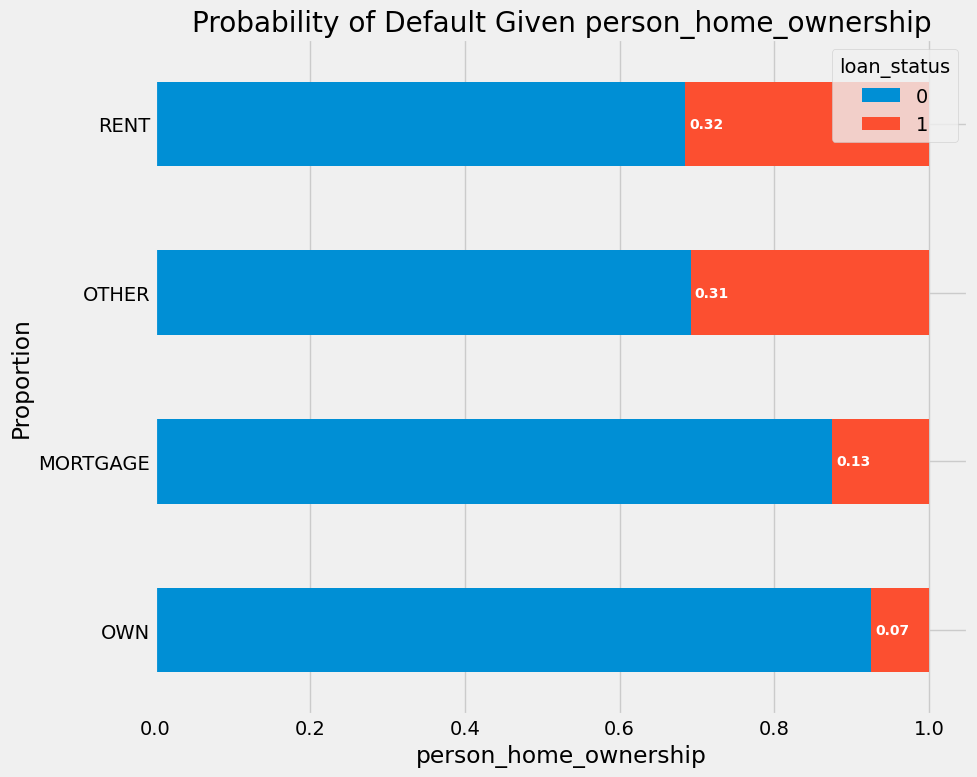

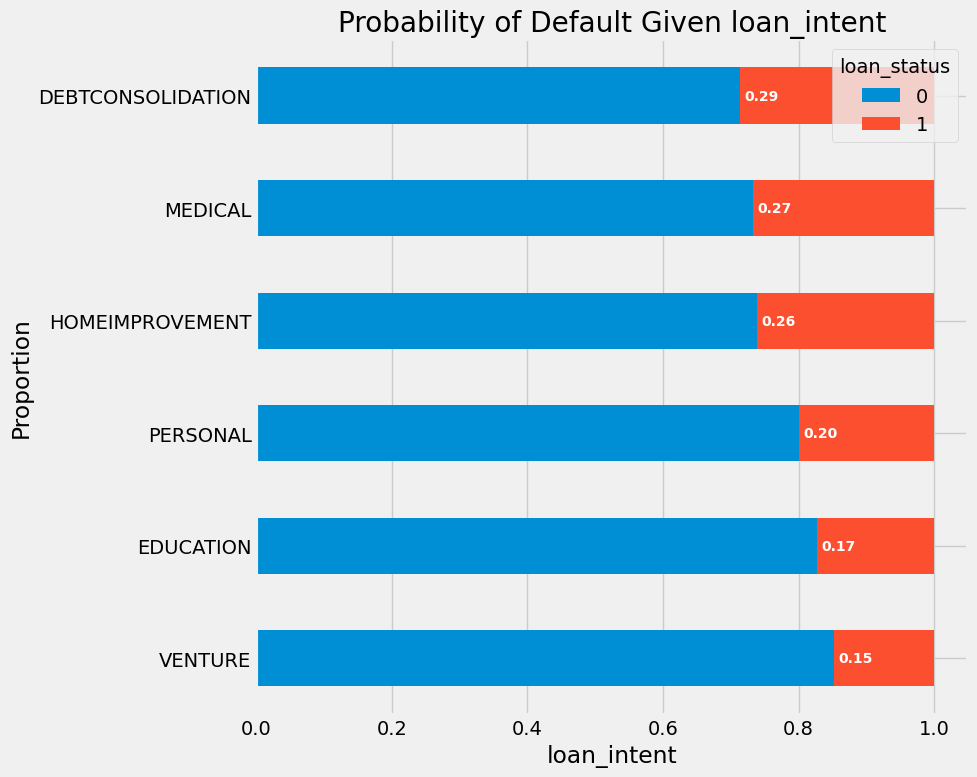

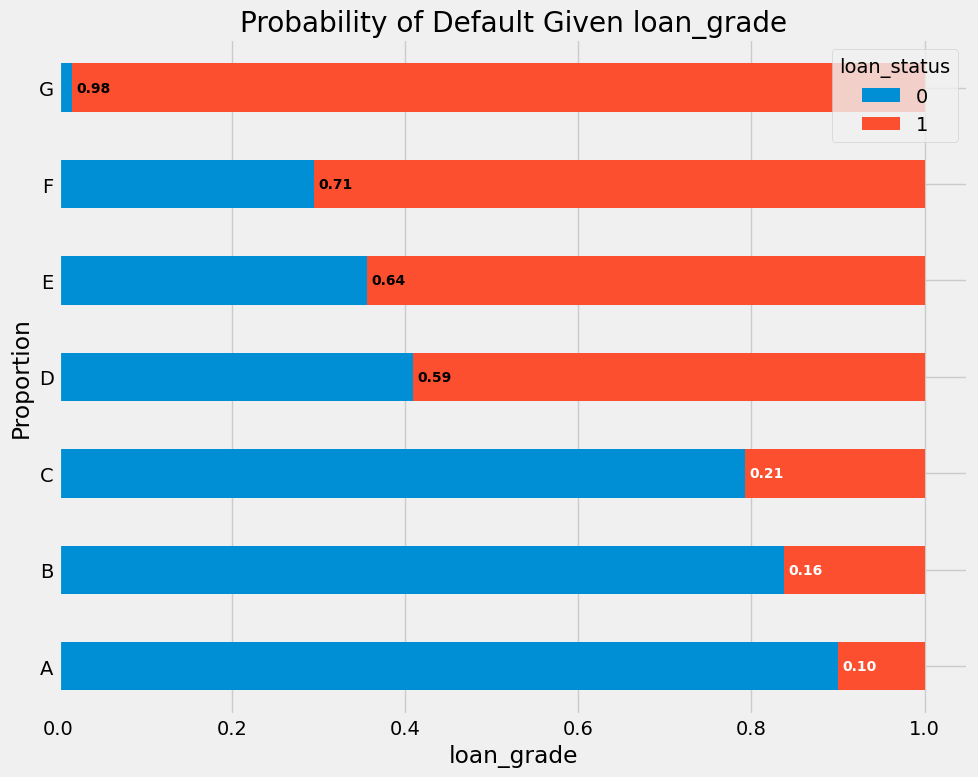

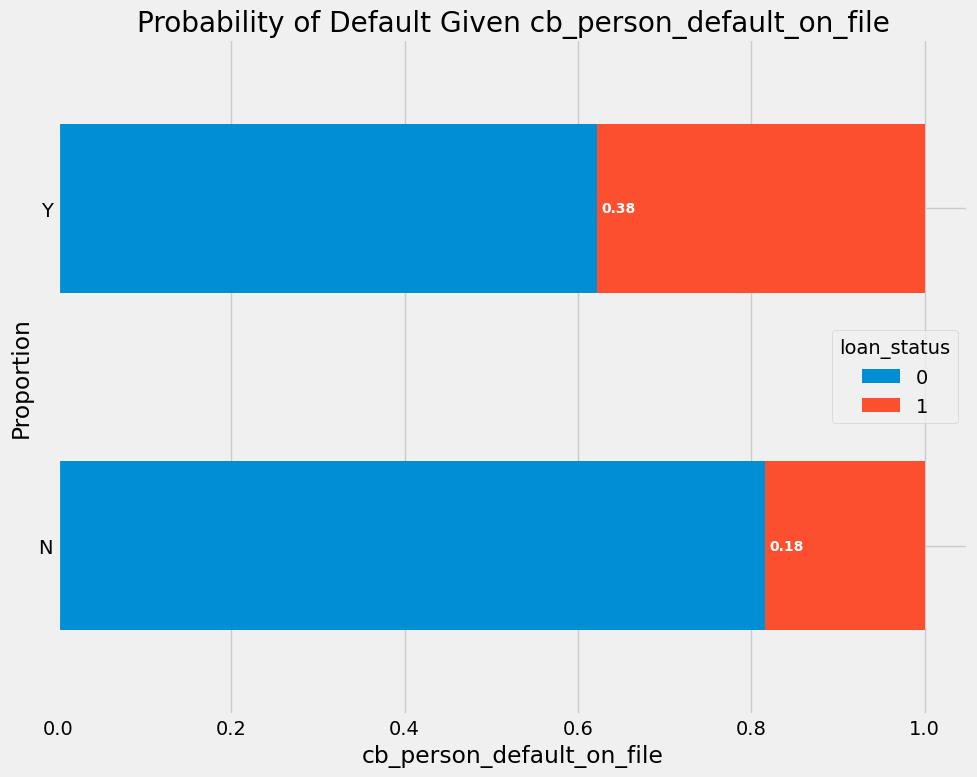

In [17]:
response_variable = 'loan_status'
for predictor_variable in df.select_dtypes('object').columns:
    plot_probability_response_by_categorical(df, predictor_variable, response_variable, (10, 8))

#### Answer
1. `person_home_ownership`: The probability of default is highest among those who still **rent** (32%) and those with **other types** of home ownership (31%).
2. `loan_intent`: The probability of loan default is highest among those who took out loans for **debt consolidation** (29%), followed by **medical needs** (27%), **home improvement** (26%), **personal loans** (20%), **education loans** (17%), and **ventures** (15%).
3. `loan_grade`: The probability of loan default is higher for those who has grade **G** (98%), **F** (71%), **E** (64%), and **D** (59%).
4. `cb_person_default_on_file`: The probability of loan default is higher for those who has history of default (38%).

### How is the correlation amongst numerical predictor variable? (Multicollinearity)
Check if there's an correlation between amongst numerical predictor variables.

In [18]:
def plot_heatmap(df: pd.DataFrame, figsize: Tuple[int, int]) -> None:
    """
    Show the visualization of coefficient correlation amongst features.
    
    Parameters
    ------------
        df (pd.DataFrame): The dataframe containing the data.
        figsize (Tuple[int, int]): size of the plot.
    Returns
    ------------
        None
    """
    _, ax = plt.subplots(figsize=figsize)  # Create a figure

    # Calculate the coefficient correlation
    corr = df.select_dtypes(include='number').corr()

    # Plot the heatmap
    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", ax=ax)
    ax.set_title('Correlation Matrix Heatmap')
    plt.tight_layout()
    # plt.savefig(f"../reports/figures/correlation_matrix_heatmap.png")
    plt.show()

In [19]:
plot_heatmap(df, FIGSIZE)

NameError: name 'FIGSIZE' is not defined

In [21]:
def plot_scatter(df: pd.DataFrame, x: str, y: str, figsize: Tuple[int, int]) -> None:
    """
    Show scatter plot between two numerical columns.
    
    Parameters
    ------------
        df (pd.DataFrame): The dataframe containing the data.
        x (str): numerical column for the x-axis.
        y (str): numerical column for the y-axis.
        figsize (Tuple[int, int]): size of the plot.
    Returns
    ------------
        None
    """
    _, ax = plt.subplots(figsize=figsize)  # Create a figure
    
    # Create scatterplot with customized aesthetics
    sns.scatterplot(x=x, y=y, data=df, color='skyblue', ax=ax)

    # Add trend line
    sns.regplot(x=x, y=y, data=df, scatter=False, color='orange', ci=None, line_kws={'linewidth': 2}, ax=ax)

    # Add labels and title
    ax.set_title(f"Scatter Plot {x} vs {y}")
    ax.set_xlabel(x)
    ax.set_ylabel(y)

    # Show plot
    plt.tight_layout()
    # plt.savefig(f"../reports/figures/scatter_plot_{x}_vs_{y}.png")
    plt.show()

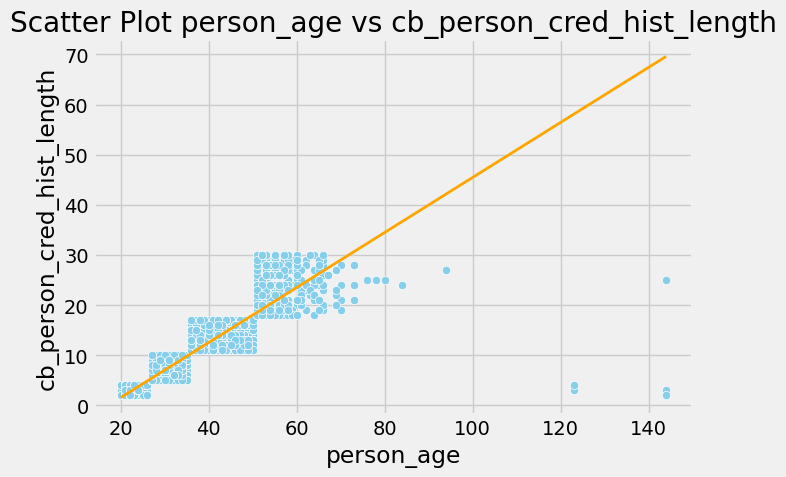

In [22]:
plot_scatter(df, "person_age", "cb_person_cred_hist_length", (7, 5))

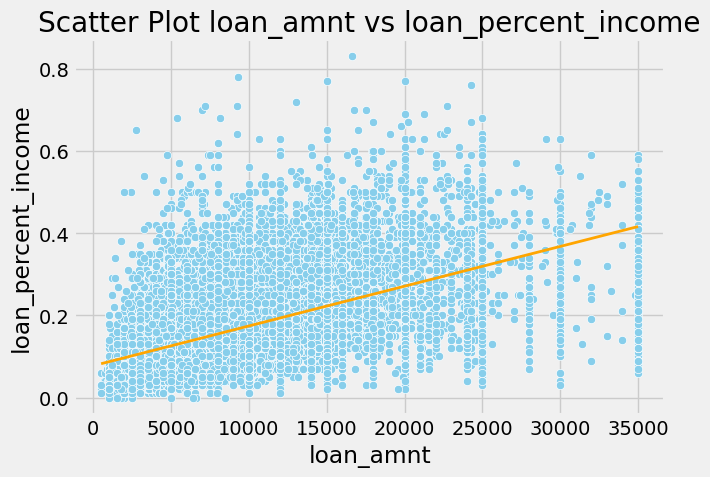

In [24]:
plot_scatter(df, "loan_amnt", "loan_percent_income", (7, 5))

#### Answer
There are multicollinearity amongst numerical predictor variable, such as: `person_age` vs `cb_person_cred_hist_length` and `loan_amnt` vs `loan_percent_income`.

# Data Preparation
1. Data Splitting: Split the data into training and testing datasets.
2. Data Cleaning: Optionally handle missing values and anomalies in the training data, then apply the same transformations to the testing dataset. Note: WoE calculation already addresses these issues.
3. Weight of Evidence (WOE) and Information Value (IV) Calculation: Calculate the WoE and IV for each predictor variable.
4. Feature Selection: Select features based on their IV scores.
5. WoE Transformation: Transform the dataset values into WoE values using the calculated WoE mappings.

## Data Splitting

In [5]:
# Prepare arguments
df = pd.read_csv('../data/raw/credit_risk_dataset.csv')
target_variable = 'loan_status'
test_size = 0.3
random_state = 42

# Split data betweem train and text
X, y = df.drop(columns=[target_variable]), df[target_variable]
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=test_size, shuffle=True, random_state=random_state)

print(f'Train features: {X_train.shape}, Train Target: {y_train.shape}')
print(f'Test features: {X_test.shape}, Test Target: {y_test.shape}')

Train features: (22806, 11), Train Target: (22806,)
Test features: (9775, 11), Test Target: (9775,)


## Weight of Evidence (WOE) and Information Value (IV)
1. ***Weight of Evidence*** (WoE) measures how good each grouped attributes (inside a predictor variable) in predicting the desired value of the binary response variable (binary classification). The formula for calculating WoE is 
    $$ \text{WoE} = \ln \left( \frac{\text{Proportion of Good}}{\text{Proportion of Bad}} \right) $$
    Where:
    - $ \text{Proportion of Good} $ is the proportion of customers who paid back (**Good Customers**).
    - $ \text{Proportion of Bad}\ $ is the proportion of default customers (**Bad Customers**).
    - $ \text{ln} $ denotes the natural logarithm.

    How to interpret WoE? High positive value of WoE leads to a high proportion of Good Customers while the lower the value of WoE leads to a high proportion of Bad Customers.

2. ***Information Value*** (IV) is to measure the predictive power of the feature on the value of the specified binary response variable (0 or 1). The formula for calculating the IV is
    $$ \text{WoE} = \sum (\text{Proportion of Good} - \text{Proportion of Bad}) * \text{WoE} $$
    Here is the table shows the interpretation of each IV.
    | Information Value | Predictive Power                        |
    |-------------------|-----------------------------------------|
    | < 0.02            | Useless in modelling                    |
    | 0.02 - 0.1        | Weak predictor                          |
    | 0.1 - 0.3         | Medium predictor                        |
    | 0.3 - 0.5         | Strong predictor                        |
    | > 0.5             | Suspiciously good. Check further        |
    
    How to interpret IV? High value of IV leads to high predictive power of a feature. IV can also be used for feature selection which works by leaving out features with low IV. 


In [6]:
from src.features.woe_transformer import WOETransformer
woe_transformer = WOETransformer(
    numerical_columns=X_train.select_dtypes('number').columns, 
    categorical_columns=X_train.select_dtypes(['object', 'category']).columns, 
    bins=5
)
woe_transformer = woe_transformer.fit(X_train, y_train)
woe_transformer

WOETransformer(bins=5,
               categorical_columns=Index(['person_home_ownership', 'loan_intent', 'loan_grade',
       'cb_person_default_on_file'],
      dtype='object'),
               numerical_columns=Index(['person_age', 'person_income', 'person_emp_length', 'loan_amnt',
       'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length'],
      dtype='object'))

In [7]:
# View information value
woe_transformer.iv_df

,Characteristic,Information Value,Interpretation
0,loan_grade,0.858398,Very Strong Predictive
0,loan_percent_income,0.710041,Very Strong Predictive
0,loan_int_rate,0.588036,Very Strong Predictive
0,person_income,0.463841,Strong Predictive
0,person_home_ownership,0.386431,Strong Predictive
0,cb_person_default_on_file,0.159914,Medium Predictive
0,loan_intent,0.088282,Weak Predictive
0,loan_amnt,0.076291,Weak Predictive
0,person_emp_length,0.057947,Weak Predictive
0,person_age,0.006026,Not Predictive


Exclude Characteristic with is interpret as `Not Predictive`

In [8]:
def plot_weight_of_evidence(df: pd.DataFrame, characteristic: str) -> None:
    """
    Plot the Weight of Evidence (WOE) for a specified characteristic.
    
    Args:
        df (pd.DataFrame): DataFrame containing the data with 'Characteristic', 'Characteristic Value', and 'WOE' columns.
        characteristic (str): The characteristic for which to plot the WOE.
    Returns:
        None
    """
    plt.style.use('fivethirtyeight')
    filtered_df = df[df['Characteristic'] == characteristic]

    fig, ax = plt.subplots()

    # Plot the WOE using barplot and point plot
    sns.barplot(x='Value', y='WOE', data=filtered_df, ax=ax)
    sns.pointplot(x='Value', y='WOE', data=filtered_df, linestyles='--', color="red", markers="o", ax=ax)
    
    # Add title, x-label and y-label
    ax.set_title(f'WOE for {characteristic}', fontweight='bold')
    ax.set_xlabel(characteristic)
    ax.set_ylabel('Weight of Evidence (WOE)', fontsize=14)
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Display the plot
    return fig

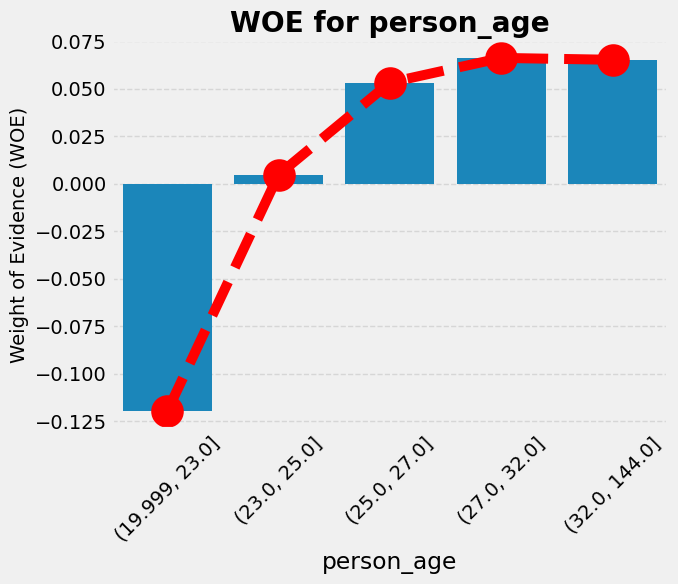

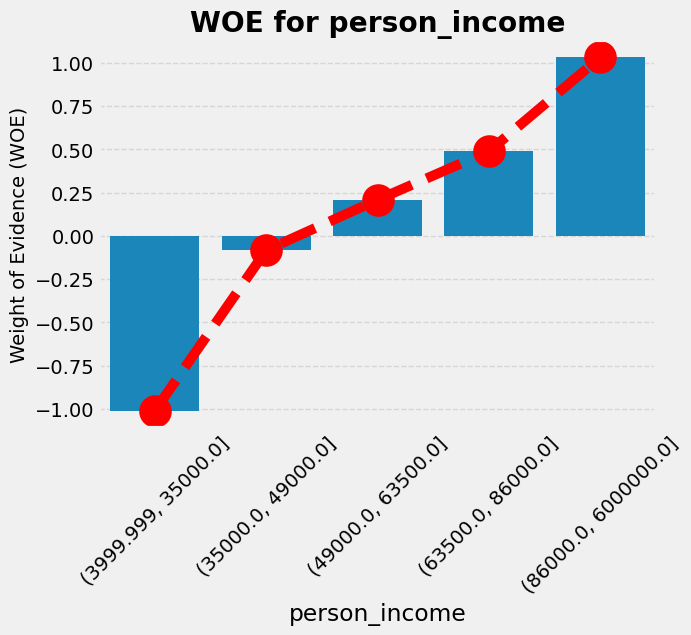

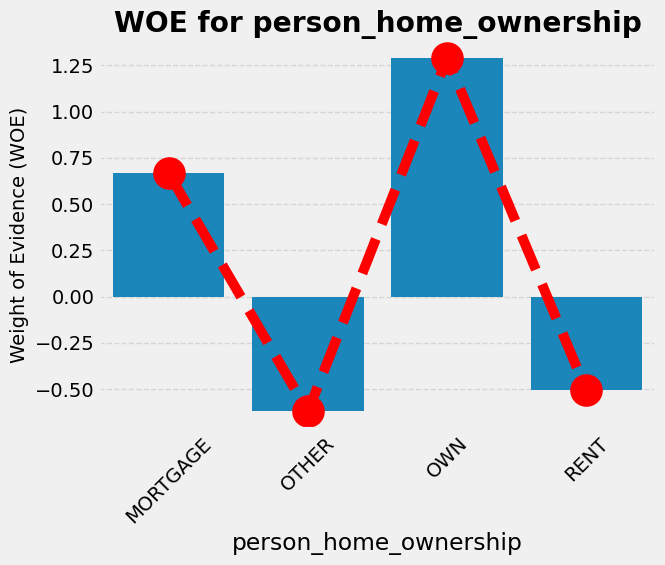

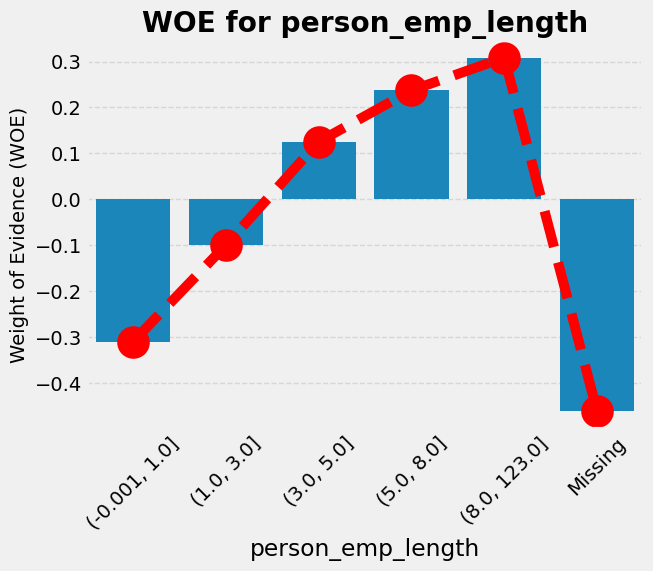

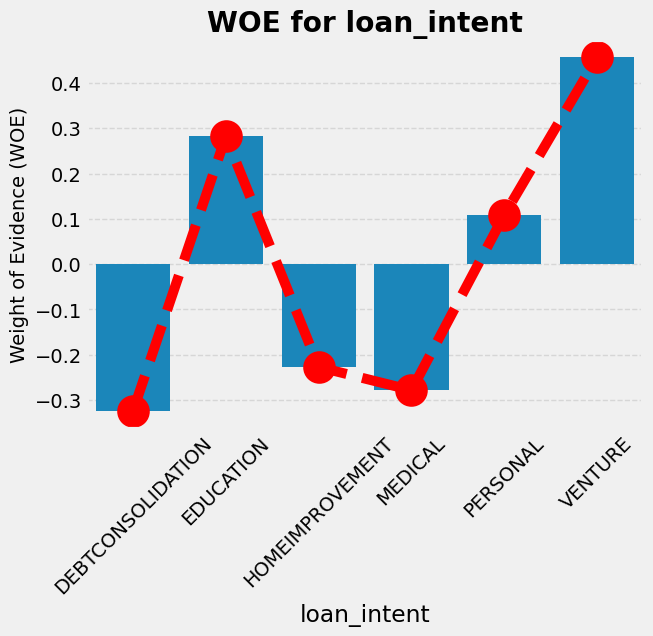

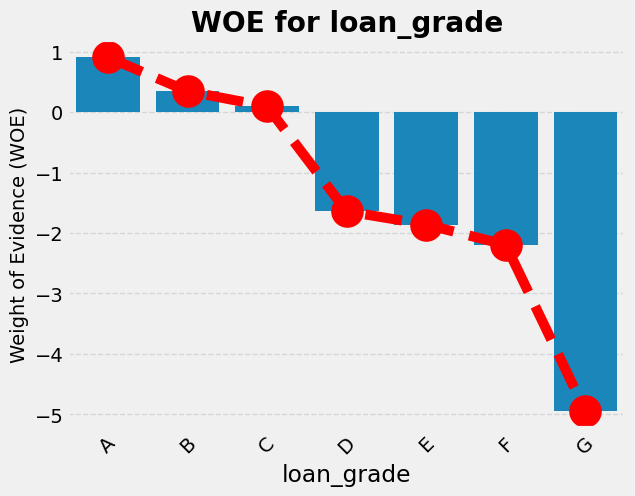

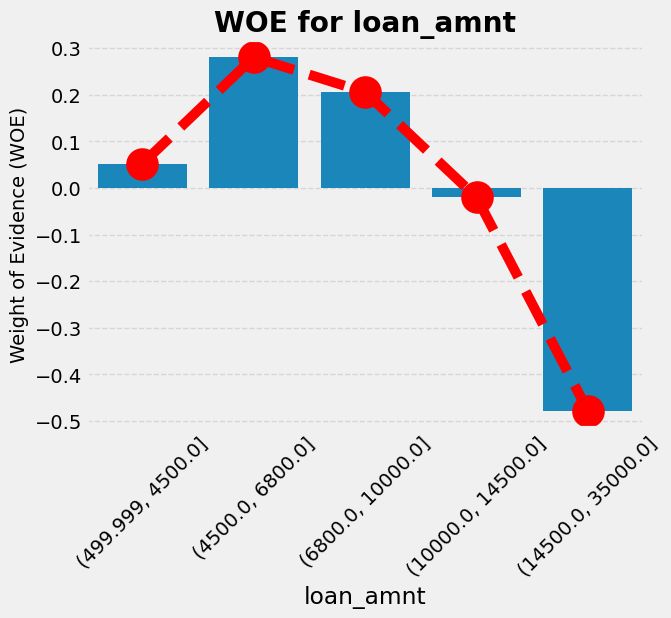

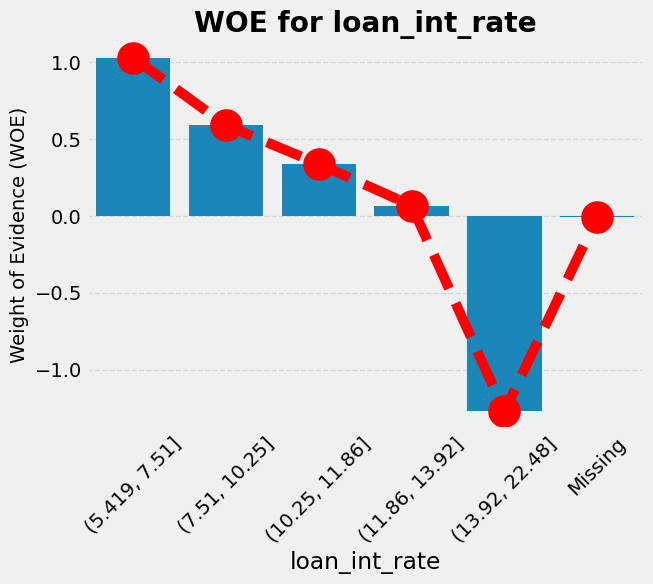

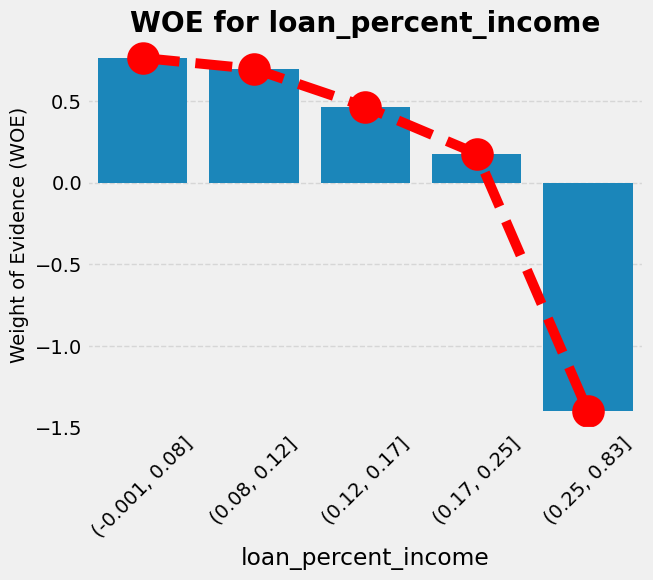

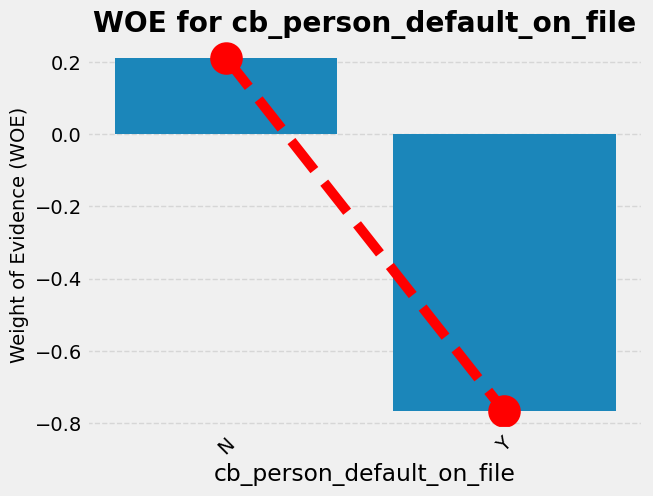

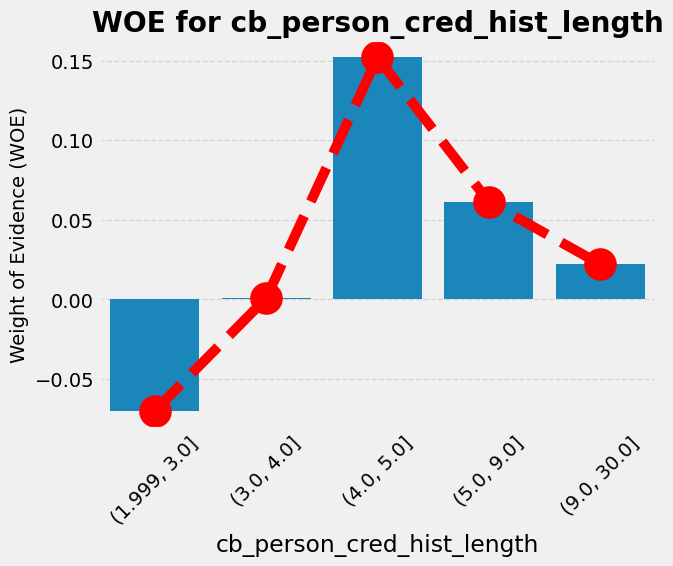

In [9]:
characteristic_names = woe_transformer.woe_df['Characteristic'].unique()
for characteristic in characteristic_names:
    plot_weight_of_evidence(woe_transformer.woe_df, characteristic)
    plt.show()

1. Those who are still producing low income has a high probability of default.
2. Those who are still new in the job has a high probability of default.
3. High interest rate (`loan_int_rate`) has a high probability of default.
4. Hihg proportion of loan with respect to income (`loan_percent_income`) has a high probability of default. 

When we plot the WoE values, we want to look for monotonicity, which means the WoE values should either gradually increase or decrease. 

### Why is Monotonicity Important?

Monotonicity indicates a consistent, predictable relationship between the predictor variable and the response variable. This is particularly important for the following reasons:

1. **Model Stability:** Monotonic relationships lead to more stable and reliable models. Non-monotonic relationships can introduce noise and reduce the model's ability to generalize well to unseen data.

2. **Interpretability:** Monotonic WoE values make the model more interpretable. It is easier to explain that as the value of a certain variable increases, the risk of default increases (or decreases), which is intuitive for stakeholders.

3. **Logistic Regression Compatibility:** Logistic regression assumes a linear relationship between the independent variables and the log-odds of the dependent variable. Monotonic WoE values help to satisfy this assumption, as they reflect a more straightforward relationship that logistic regression can capture effectively.

# Modelling
Use Logistic Regression due to its simplicity, interpretability, and transparency in prediction.

In [10]:
from src.models.woe_logistic_regression import WOELogisticRegression

# Train
woe_transformer_params = {
    'numerical_columns': X_train.select_dtypes("number").columns,
    'categorical_columns': X_train.select_dtypes(["object", "category"] ).columns,
    'bins': 5,
}
logreg_params = {
    'random_state': 42
}
woe_logreg_model = WOELogisticRegression.from_parameters(
    woe_transformer_params = woe_transformer_params,
    logreg_params = logreg_params,
)

woe_logreg_model.fit(X_train, y_train)

2024-07-13 15:14:00,323 - credit-scorecard-logger - INFO - Pipeline model created
2024-07-13 15:14:01,860 - credit-scorecard-logger - INFO - Pipeline model training finished in 1.54 seconds.


WOELogisticRegression(pipeline=Pipeline(steps=[('WOETransformer',
                                                WOETransformer(bins=5,
                                                               categorical_columns=Index(['person_home_ownership', 'loan_intent', 'loan_grade',
       'cb_person_default_on_file'],
      dtype='object'),
                                                               numerical_columns=Index(['person_age', 'person_income', 'person_emp_length', 'loan_amnt',
       'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length'],
      dtype='object'))),
                                               ('LogisticRegression',
                                                LogisticRegression(random_state=42))]))

# Model Explanation

In [11]:
intercept = woe_logreg_model.pipeline[LogisticRegression.__name__].intercept_[0]
coef = woe_logreg_model.pipeline[LogisticRegression.__name__].coef_.reshape(-1)
features = woe_logreg_model.pipeline[LogisticRegression.__name__].feature_names_in_
print("Intercept: ", intercept)
print("Coef:")
for feature, coef in zip(features, coef):
    print(f"{feature} = {coef:.5f}")

Intercept:  -1.3382882960524072
Coef:
person_age = -0.32358
person_income = -0.92974
person_home_ownership = -0.87770
person_emp_length = -0.27826
loan_intent = -1.33985
loan_grade = -1.14854
loan_amnt = -0.81561
loan_int_rate = -0.02510
loan_percent_income = -0.83871
cb_person_default_on_file = 0.04566
cb_person_cred_hist_length = -0.33327


## Explanation
Explanation of parameters inside the Logistic Regression:
1. Intercept (`intercept_`): It's the average chance of default when all other predictor variables are zero.
2. Coefficients (`coef_`): These numbers show how much each factor affects the chance of default:
    - Negative numbers mean the factor lowers the chance of default. For example, if weight of evidence person_income goes up, the chance of default goes down.
    - Positive numbers mean the factor increases the chance of default. For instance, if weight of evidence cb_person_default_on_file is 'Yes', it increases the chance of default.

Based on these coefficients if the Weight of Evidence is positively big (high percentage of non default customers) the lower the change of default because it is multiploed by the negative coefficient. Otherwise if the Weight of Evidence is massively negative (high percentage of non customers) the higher the chance of default because massive negatice values multiplied by negative coefficients result in positive log of the odds which increase the probability of default in the final prediction.

# Evaluation
Evaluation metrics that are chosen are used to assess the ***model's discriminative ability*** rather than conventional classification metrics like recall, precision, and F1-score: While recall, precision, and F1-score are useful in many classification contexts, credit risk models are often evaluated on their ability to rank-order risk and their calibration.
    
Evaluation metrics that are being chosen are:
- ***ROC AUC (Receiver Operating Characteristic Area Under the Curve)***: Measures the model's ability to distinguish between classes. It provides an aggregate measure of performance across all classification thresholds.
- ***Precision-Recall Curve***: Particularly useful in cases of imbalanced classes. It focuses on the performance related to the positive class (default cases).
- ***Gini Coefficient***: A variant of the AUC, often used in credit scoring, which ranges from 0 to 1. It measures the ability of the model to differentiate between good and bad accounts.
- ***Kolmogorov-Smirnov (KS) Statistic***: Evaluates the maximum separation between the cumulative distributions of the good and bad accounts. Higher KS values indicate better model performance.
- ***Model Calibration***: Assesses how well the predicted probabilities of default align with the actual default rates. Good calibration means that the predicted risk levels reflect true risks accurately.

In [12]:
def print_side_by_side(dict1: dict, dict2: dict) -> None:
    """
    Prints the content of two dictionaries side by side.

    Args:
        dict1 (dict): The first dictionary to be printed.
        dict2 (dict): The second dictionary to be printed.

    Returns:
        None
    """
    # Calculate the maximum length of keys in both dictionaries
    max_key_len = max(max(len(key) for key in dict1), max(len(key) for key in dict2))
    
    # Define the format string for printing
    output = ""
    
    # Print header
    output += "{:<{key_len}}: {:<8} | {:<8}".format("Metric", "Train", "Test", key_len=max_key_len)
    output += "\n "
    
    # Print separator
    output +="-" * (max_key_len + 20)
    output += "\n "
    output = "{:<{key_len}}: {:<8} | {:<8}\n{}\n"\
        .format(
            "Metric", "Train", "Test", 
            "-" * (max_key_len + 20), 
            key_len=max_key_len
        )
    # Print key-value pairs side by side
    for key in dict1:
        output +="{:<{key_len}}: {:<8.3f} | {:<8.3f}\n".format(key, dict1[key], dict2[key], key_len=max_key_len)
    return output

2024-07-13 15:14:06,797 - credit-scorecard-logger - INFO - Pipeline model prediction probability finished in 1.06 seconds.
2024-07-13 15:14:07,855 - credit-scorecard-logger - INFO - Pipeline model prediction probability finished in 1.05 seconds.
2024-07-13 15:14:07,902 - credit-scorecard-logger - INFO - Training Performance >>> ROC AUC: 0.87, PR AUC: 0.71, GINI: 0.74, KS SCORE: 0.62
2024-07-13 15:14:07,902 - credit-scorecard-logger - INFO - Pipeline model evaluation finished in 1.10 seconds.
2024-07-13 15:14:08,362 - credit-scorecard-logger - INFO - Pipeline model prediction probability finished in 0.46 seconds.
2024-07-13 15:14:08,762 - credit-scorecard-logger - INFO - Training Performance >>> ROC AUC: 0.87, PR AUC: 0.72, GINI: 0.74, KS SCORE: 0.61
2024-07-13 15:14:08,778 - credit-scorecard-logger - INFO - Pipeline model evaluation finished in 0.87 seconds.
2024-07-13 15:14:09,788 - credit-scorecard-logger - INFO - Pipeline model prediction probability finished in 1.01 seconds.
2024-0

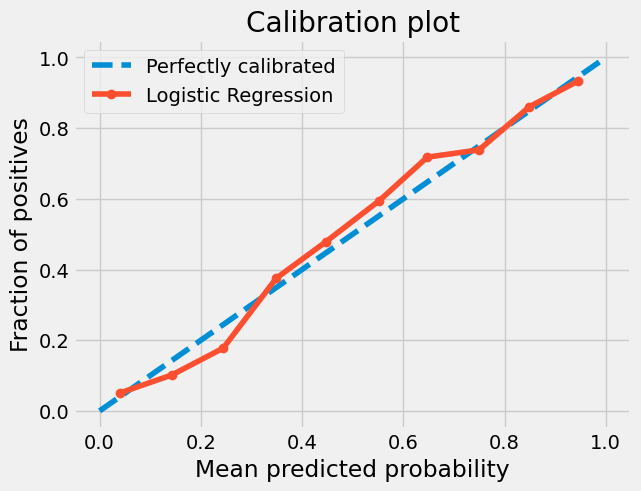

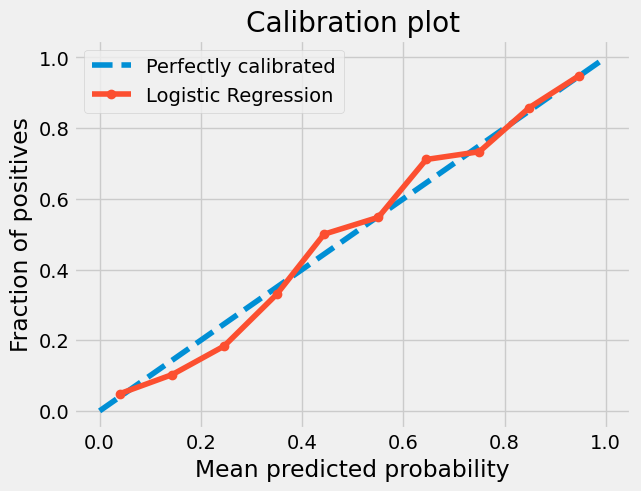

In [13]:
from src.visualization.visualize import plot_calibration_curve
y_train_pred_proba = woe_logreg_model.predict_proba(X_train)[:, -1]

woe_logreg_model.evaluate(X_train, y_train)
woe_logreg_model.evaluate(X_test, y_test)

plot_calibration_curve(y_train, woe_logreg_model.predict_proba(X_train)[:, 1], "Logistic Regression")
plot_calibration_curve(y_test, woe_logreg_model.predict_proba(X_test)[:, 1], "Logistic Regression")
plt.show()

2024-07-13 15:14:11,702 - credit-scorecard-logger - INFO - Pipeline model prediction probability finished in 1.06 seconds.


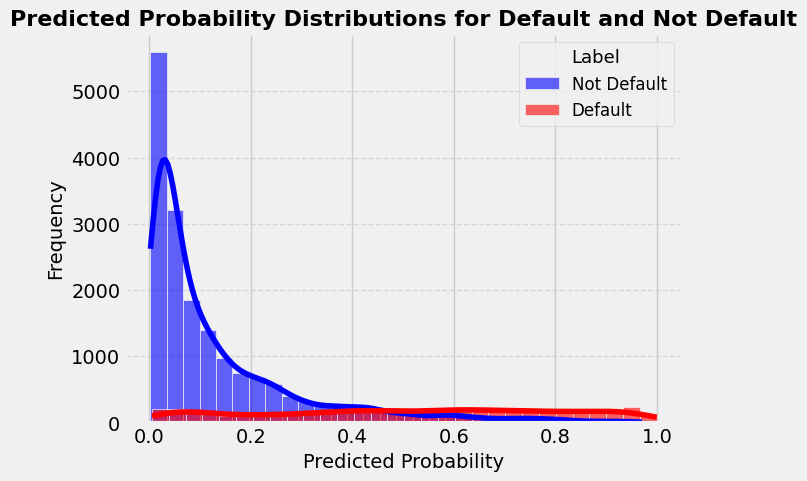

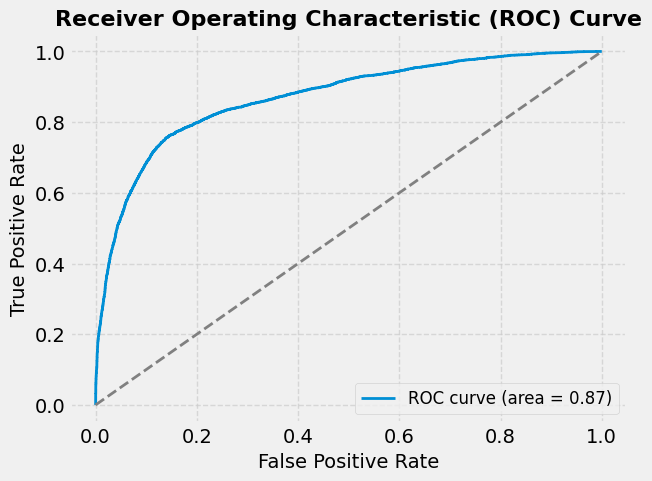

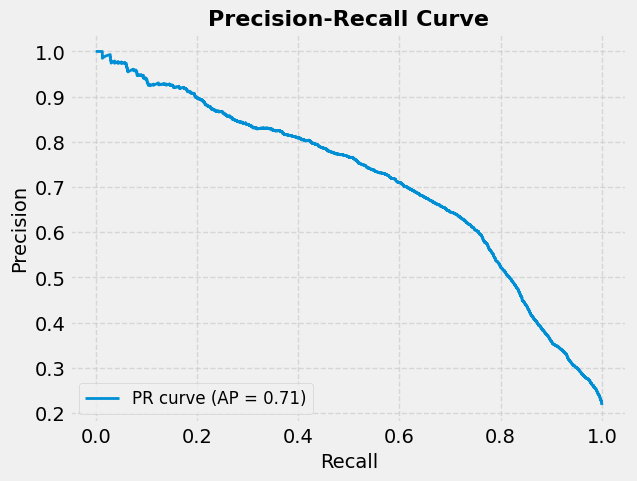

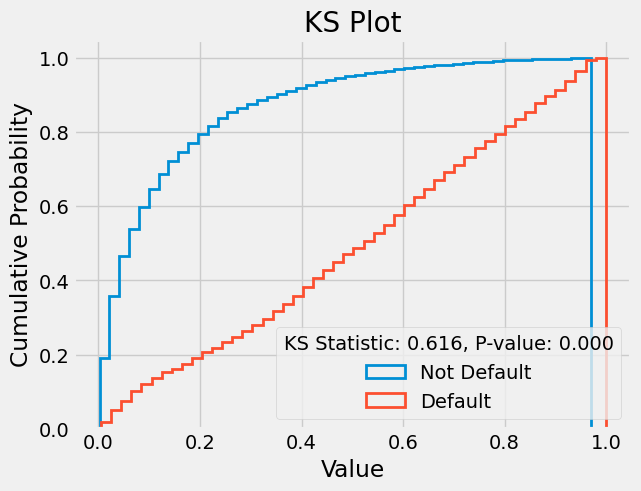

In [14]:
from src.visualization.visualize import plot_pred_proba_distribution, plot_roc_auc_curve, plot_precision_recall_curve, plot_ks
y_pred_proba = woe_logreg_model.predict_proba(X_train)[:, -1]
plot_pred_proba_distribution(y_train, y_pred_proba)
plot_roc_auc_curve(y_train, y_pred_proba)
plot_precision_recall_curve(y_train, y_pred_proba)
plot_ks(y_train, y_pred_proba)
plt.show()

## Explanation
- From the evaluation results it seems there's no indication of overfitting which is good because the model performances are similar between training and testing set
- **The most important thins is the model calibration which is close to the perfect calibrated model**. Why is it so important? it ensures all business decision makers that the model estimated probabilities aligns with the actual default rate in the population of actual borrowers. For example, if the model is perfectly calibrated and the model predict that chance of someone default is 10% and the bank trust it. For every loan given to all borrowers with predicted probabilit of default 10%, then they expect on average that 10% of all borrowers will default.
- It is impossible that the model follow the perfectly callibrated line. If it does, it could be possible indication of an overfitting. 
- If the **point lies below the perfectly calibrated line** it means that **the model underpredicting the probability of "Bad" users**. Conversely, if a **point lies above the perfectly calibrated line** it means that **the model overpredicting the probability of the a "Bad" users**.

# Scaling and Creating Scorecard
Credit scorecard will show how the Points represented by the bins generated from the predictor variable. Generating the score points will involve scaling calculations from the logistic regression parameters and WoE(s) from grouped attributes inside each characteristics. In general the relationship between the scores and odds can be presented and linear equation:
$$ \text{Score} = Offset + (Factor * \ln{(Odds)}) $$

The scorecard is being developed using a **specified odds** and **points to double the odds** (*pdo*). The $ Offset $ and $ Factor $ can be calculated by using these formula:
$$ \text{Score} = Offset + (Factor * \ln{(Odds)}) $$
$$ \text{Score} + \text{pdo} = Offset + (Factor * \ln{(2 * Odds)}) $$

By solving the equation above for getting pdo, we get:
$$ \text{pdo} = Factor * \ln{(2)} \text{, therefore } Factor = \text{pdo} / \ln{(2)} $$
$$ \text{Offset} = Score - {Factor * \ln(Odds)}$$

After calculating, Factor and Offset we can start using the same formula for calculate the total score. The difference is we replace the $ \ln{(Odds)} $ with the linear equation from the logistic regression. 
$$ \text{Score} = Offset + Factor * \ln{(Odds)} = $$
$$ \text{Score} = - (\sum_{j,i=1}^{k,n}(WoE_{j}*\beta_{i})+a) * Factor + Offset  $$
$$ \text{Score} = - (\sum_{j,i=1}^{k,n}(WoE_{j}*\beta_{i}+\frac{a}{n})) * Factor + Offset  $$
$$ \text{Score} = \sum_{j,i=1}^{k,n}(-(WoE_{j}*\beta_{i}+\frac{a}{n}) * Factor + \frac{Offset}{n})  $$

We can modify the final equation to calculate the score for each grouped attribute inside each characteristic by removing the sum because we only wanted to calculate a single attribute score.
$$ \text{Attribute Score} = -(WoE_{j}*\beta_{i}+\frac{a}{n}) * Factor + \frac{Offset}{n}  $$

Where:
- $ WOE $ = weight of evidence for each grouped attribute
- $ \beta $ = regression coefficient for each characteristic
- $ a $ = intercept term from logistic regression
- $ n $ = number of characteristics
- $ k $ = number of groups (of attributes) in each characteristic

Source: https://www.amazon.com/Credit-Risk-Scorecards-Implementing-Intelligent/dp/047175451X

In [31]:
class CreditScoreScaling:
    def __init__(self, pipeline, pdo: Union[int, float], odds: Union[int, float], scorecard_points: Union[int, float]):
        self.pipeline = pipeline 
        self.intercept = self.pipeline[LogisticRegression.__name__].intercept_[0]
        self.n_features = len(self.pipeline[LogisticRegression.__name__].feature_names_in_)
        self.pdo = pdo
        self.odds = odds
        self.scorecard_points = scorecard_points
        self.factor = self.pdo / np.log(2)
        self.offset = self.scorecard_points - self.factor * np.log(self.odds)
        self.scorecard_map_dict = {}  # for mapping values to its credit point
        
    # Private methods
    def __generate_mapping(self, scorecard: pd.DataFrame) -> None:
        # Create dictionary mapping in the background
        scorecard_features = scorecard["Characteristic"].unique()

        for feature in scorecard_features:
            self.scorecard_map_dict[feature] = {row["Value"]: row["Points"] for _, row in scorecard[scorecard["Characteristic"]==feature].iterrows()}

    def __get_credit_point(self, feature: str, value: Union[int, float, str]) -> float:
        credit_point = None
        if isinstance(value, int) or isinstance(value, float):
            for interval, woe in self.scorecard_map_dict[feature].items():
                if isinstance(interval, pd.Interval) and value in interval:
                    credit_point = woe
            credit_point = self.scorecard_map_dict[feature].get("Missing", None) if credit_point is None else credit_point 
        elif isinstance(value, str):
            credit_point = self.scorecard_map_dict[feature][value]
        return credit_point
    
    
    # Public methods
    def generate_scorecard(self) -> pd.DataFrame:
        model_summary = pd.DataFrame({
            "Characteristic": self.pipeline[LogisticRegression.__name__].feature_names_in_,
            "Estimate": self.pipeline[LogisticRegression.__name__].coef_.reshape(-1)
        })

        self.scorecard = pd.merge(
            left = model_summary,
            right = self.pipeline[WOETransformer.__name__].woe_df, 
            how = "left",
            on = ["Characteristic"]
        )
        self.scorecard['Points'] = (self.offset/self.n_features) - self.factor * ((self.scorecard['WOE'] * self.scorecard['Estimate'])+(self.intercept/self.n_features))
        self.__generate_mapping(self.scorecard)
    
    
    
    def calculate_single_credit_score(self, data: dict) -> dict:
        details = {feature: self.__get_credit_point(feature, value) for feature, value in data.items()}
        details['credit_score'] = sum(details.values())
        return details
    

    def calculate_credit_score(self, X: pd.DataFrame) -> pd.DataFrame:
        index = X.index
        results = X.apply(lambda instance: self.calculate_single_credit_score(instance.to_dict()), axis=1)
        return pd.DataFrame.from_dict(results.tolist()).set_index(index)
    

In [16]:
credit_score = CreditScoreScaling(woe_logreg_model.pipeline, 20, 1, 500)
credit_score.generate_scorecard()
credit_score.calculate_credit_score(X_test.copy(deep=False))

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,credit_score
28004,49.461572,54.560406,65.816138,49.971659,38.205620,-5.474716,48.490425,48.043549,53.260788,48.686506,49.178408,500.200356
15942,49.461572,21.862707,36.146427,45.263167,59.858042,78.942682,50.197823,49.711276,15.068757,48.686506,48.291440,503.490399
26343,49.582520,76.646790,81.624689,49.971659,66.602833,52.017663,48.490425,49.014310,65.822148,49.975218,49.555411,639.303666
16374,47.847196,54.560406,65.816138,46.478403,53.159019,52.017663,53.803254,49.210605,60.228788,48.686506,48.972207,580.780186
27301,49.582520,76.646790,65.816138,51.441322,66.602833,78.942682,37.714962,49.393084,60.228788,48.686506,49.555411,634.611036
...,...,...,...,...,...,...,...,...,...,...,...,...
21232,49.582520,46.741691,65.816138,46.478403,59.858042,52.017663,48.490425,48.960972,15.068757,49.975218,49.555411,532.545239
22172,49.582520,46.741691,36.146427,49.971659,38.205620,52.017663,55.568360,49.014310,60.228788,49.975218,49.555411,537.007667
2214,49.461572,46.741691,36.146427,48.163805,53.159019,60.336469,48.490425,49.210605,15.068757,48.686506,48.291440,503.756716
20705,49.573253,21.862707,36.146427,46.478403,53.159019,78.942682,55.568360,49.393084,60.228788,48.686506,50.428332,550.467562


In [18]:
# Prepare input data
input_df = X_test.copy()

# Calculate the credit score
credit_scores_df = credit_score.calculate_credit_score(input_df.copy(deep=False))
credit_scores_df

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,credit_score
28004,49.461572,54.560406,65.816138,49.971659,38.205620,-5.474716,48.490425,48.043549,53.260788,48.686506,49.178408,500.200356
15942,49.461572,21.862707,36.146427,45.263167,59.858042,78.942682,50.197823,49.711276,15.068757,48.686506,48.291440,503.490399
26343,49.582520,76.646790,81.624689,49.971659,66.602833,52.017663,48.490425,49.014310,65.822148,49.975218,49.555411,639.303666
16374,47.847196,54.560406,65.816138,46.478403,53.159019,52.017663,53.803254,49.210605,60.228788,48.686506,48.972207,580.780186
27301,49.582520,76.646790,65.816138,51.441322,66.602833,78.942682,37.714962,49.393084,60.228788,48.686506,49.555411,634.611036
...,...,...,...,...,...,...,...,...,...,...,...,...
21232,49.582520,46.741691,65.816138,46.478403,59.858042,52.017663,48.490425,48.960972,15.068757,49.975218,49.555411,532.545239
22172,49.582520,46.741691,36.146427,49.971659,38.205620,52.017663,55.568360,49.014310,60.228788,49.975218,49.555411,537.007667
2214,49.461572,46.741691,36.146427,48.163805,53.159019,60.336469,48.490425,49.210605,15.068757,48.686506,48.291440,503.756716
20705,49.573253,21.862707,36.146427,46.478403,53.159019,78.942682,55.568360,49.393084,60.228788,48.686506,50.428332,550.467562


## Point Allocation Checking
See if the allocation poitns to each bin make sense

In [19]:
# Point allocation checking
for variable in credit_score.scorecard['Characteristic'].unique():
    mask = credit_score.scorecard['Characteristic'] == variable
    display(variable, credit_score.scorecard[mask])

'person_age'

,Characteristic,Estimate,Value,WOE,Points
0,person_age,-0.32358,"(19.999, 23.0]",-0.119722,47.847196
1,person_age,-0.32358,"(23.0, 25.0]",0.004753,49.009362
2,person_age,-0.32358,"(25.0, 27.0]",0.053187,49.461572
3,person_age,-0.32358,"(27.0, 32.0]",0.066142,49.582520
4,person_age,-0.32358,"(32.0, 144.0]",0.065149,49.573253


'person_income'

,Characteristic,Estimate,Value,WOE,Points
5,person_income,-0.929738,"(3999.999, 35000.0]",-1.010278,21.862707
6,person_income,-0.929738,"(35000.0, 49000.0]",-0.082877,46.741691
7,person_income,-0.929738,"(49000.0, 63500.0]",0.208578,54.560406
8,person_income,-0.929738,"(63500.0, 86000.0]",0.488916,62.080914
9,person_income,-0.929738,"(86000.0, 6000000.0]",1.031880,76.646790


'person_home_ownership'

,Characteristic,Estimate,Value,WOE,Points
10,person_home_ownership,-0.8777,MORTGAGE,0.665394,65.816138
11,person_home_ownership,-0.8777,OTHER,-0.621106,33.235418
12,person_home_ownership,-0.8777,OWN,1.289619,81.624689
13,person_home_ownership,-0.8777,RENT,-0.506161,36.146427


'person_emp_length'

,Characteristic,Estimate,Value,WOE,Points
14,person_emp_length,-0.278263,"(-0.001, 1.0]",-0.309702,46.478403
15,person_emp_length,-0.278263,"(1.0, 3.0]",-0.099786,48.163805
16,person_emp_length,-0.278263,"(3.0, 5.0]",0.125380,49.971659
17,person_emp_length,-0.278263,"(5.0, 8.0]",0.237180,50.869293
18,person_emp_length,-0.278263,"(8.0, 123.0]",0.308425,51.441322
19,person_emp_length,-0.278263,Missing,-0.461058,45.263167


'loan_intent'

,Characteristic,Estimate,Value,WOE,Points
20,loan_intent,-1.339854,DEBTCONSOLIDATION,-0.323869,36.444211
21,loan_intent,-1.339854,EDUCATION,0.281765,59.858042
22,loan_intent,-1.339854,HOMEIMPROVEMENT,-0.227074,40.186301
23,loan_intent,-1.339854,MEDICAL,-0.278307,38.205620
24,loan_intent,-1.339854,PERSONAL,0.108485,53.159019
25,loan_intent,-1.339854,VENTURE,0.456230,66.602833


'loan_grade'

,Characteristic,Estimate,Value,WOE,Points
26,loan_grade,-1.148536,A,0.904584,78.942682
27,loan_grade,-1.148536,B,0.343137,60.336469
28,loan_grade,-1.148536,C,0.092115,52.017663
29,loan_grade,-1.148536,D,-1.642731,-5.474716
30,loan_grade,-1.148536,E,-1.860620,-12.695486
31,loan_grade,-1.148536,F,-2.196718,-23.833682
32,loan_grade,-1.148536,G,-4.940075,-114.747834


'loan_amnt'

,Characteristic,Estimate,Value,WOE,Points
33,loan_amnt,-0.815612,"(499.999, 4500.0]",0.052386,50.197823
34,loan_amnt,-0.815612,"(4500.0, 6800.0]",0.280594,55.568360
35,loan_amnt,-0.815612,"(6800.0, 10000.0]",0.205590,53.803254
36,loan_amnt,-0.815612,"(10000.0, 14500.0]",-0.020165,48.490425
37,loan_amnt,-0.815612,"(14500.0, 35000.0]",-0.478041,37.714962


'loan_int_rate'

,Characteristic,Estimate,Value,WOE,Points
38,loan_int_rate,-0.025104,"(5.419, 7.51]",1.030296,49.711276
39,loan_int_rate,-0.025104,"(7.51, 10.25]",0.591014,49.393084
40,loan_int_rate,-0.025104,"(10.25, 11.86]",0.339091,49.210605
41,loan_int_rate,-0.025104,"(11.86, 13.92]",0.068096,49.014310
42,loan_int_rate,-0.025104,"(13.92, 22.48]",-1.272094,48.043549
43,loan_int_rate,-0.025104,Missing,-0.005541,48.960972


'loan_percent_income'

,Characteristic,Estimate,Value,WOE,Points
44,loan_percent_income,-0.838708,"(-0.001, 0.08]",0.763363,67.438353
45,loan_percent_income,-0.838708,"(0.08, 0.12]",0.696577,65.822148
46,loan_percent_income,-0.838708,"(0.12, 0.17]",0.465447,60.228788
47,loan_percent_income,-0.838708,"(0.17, 0.25]",0.177513,53.260788
48,loan_percent_income,-0.838708,"(0.25, 0.83]",-1.400671,15.068757


'cb_person_default_on_file'

,Characteristic,Estimate,Value,WOE,Points
49,cb_person_default_on_file,0.045663,N,0.211359,48.686506
50,cb_person_default_on_file,0.045663,Y,-0.766741,49.975218


'cb_person_cred_hist_length'

,Characteristic,Estimate,Value,WOE,Points
51,cb_person_cred_hist_length,-0.333269,"(1.999, 3.0]",-0.070043,48.291440
52,cb_person_cred_hist_length,-0.333269,"(3.0, 4.0]",0.000751,48.972207
53,cb_person_cred_hist_length,-0.333269,"(4.0, 5.0]",0.152177,50.428332
54,cb_person_cred_hist_length,-0.333269,"(5.0, 9.0]",0.061400,49.555411
55,cb_person_cred_hist_length,-0.333269,"(9.0, 30.0]",0.022194,49.178408


`loan_amount` points doesn't show any increasing or decreasing value this might be due to the fact that the loan amount (big or small) doesn't matter as long as the applicant has high income. 

## Present Report to User/ Management

In [20]:
# Prepare input data
input_df = X_test.copy()

# Calculate the credit score
credit_scores_df = credit_score.calculate_credit_score(input_df.copy(deep=False))

# Interpret the credit score
# credit_scores_df = credit_score.interpret_credit_score(credit_scores_df, target_col ='credit_score')
credit_scores_df["loan_status"] = y_test

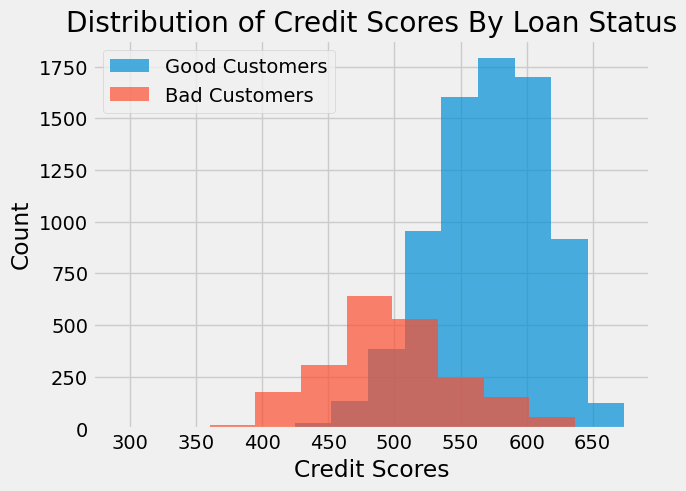

In [21]:
credit_scores_df.loc[credit_scores_df["loan_status"]==0, "credit_score"].hist(alpha=0.7, label="Good Customers")
credit_scores_df.loc[credit_scores_df["loan_status"]==1, "credit_score"].hist(alpha=0.7, label="Bad Customers")
plt.title("Distribution of Credit Scores By Loan Status")
plt.xlabel("Credit Scores")
plt.ylabel("Count")
plt.legend()
plt.savefig("../reports/figures/distribution_of_credit_scores_by_loan_status.png")
plt.show()

This shows that customers has a high chance of default if their credit scores are low.

In [29]:
# Create report to management
CREDIT_LEVELS_DESCRIPTIONS = {
    1: "Very Poor",
    2: "Poor",
    3: "Below Average",
    4: "Average",
    5: "Above Average",
    6: "Good",
    7: "Very Good",
    8: "Excellent",
    9: "Exceptional",
}
LEVEL_BOUNDS = [float('-inf'), 350, 400, 450, 500, 550, 600, 650, 700, float('inf')]

def interpret_credit_score(
        df: pd.DataFrame,
        target_col: str,
    ) -> pd.DataFrame:
    conditions = [
        (df[target_col] > LEVEL_BOUNDS[i]) & (df[target_col] <= LEVEL_BOUNDS[i+1])
        for i in range(len(LEVEL_BOUNDS) - 1)
    ]

    level_choices = list(CREDIT_LEVELS_DESCRIPTIONS.keys())
    lower_bound_choices = LEVEL_BOUNDS[:-1]
    upper_bound_choices = LEVEL_BOUNDS[1:]
    df["credit_level"] = np.select(conditions, level_choices)
    df["credit_lower_bound"] = np.select(conditions, lower_bound_choices)
    df["credit_upper_bound"] = np.select(conditions, upper_bound_choices)
    df["credit_description"] = df["credit_level"].map(CREDIT_LEVELS_DESCRIPTIONS)
    return df

def generate_report(df: pd.DataFrame) -> pd.DataFrame:
    # Count every Good Users and Bad Users in each credit levels
    report_df = interpret_credit_score(df, target_col='credit_score')
    report_df = report_df\
        .groupby(["credit_level", "credit_lower_bound", "credit_upper_bound", "credit_description"])["loan_status"]\
        .value_counts()\
        .unstack()\
        .reset_index()\
        .rename(columns={
            0: "Good Customers",
            1: "Bad Customers",
            "credit_level": "Credit Level",
            "credit_lower_bound": "Credit Lower Bound", 
            "credit_upper_bound": "Credit Upper Bound", 
            "credit_description": "Credit Description"
        })\
        .fillna(0)

    report_df = report_df.rename_axis(None, axis=1)
    report_df["Customers"] = report_df["Good Customers"] + report_df["Bad Customers"]

    # Proportion of customers exists in each credit levels
    report_df["Customers Rate"] = report_df["Customers"] / report_df["Customers"].sum() * 100
    
    # Proportion of `Bad Customers`` in each credit levels
    report_df["Default Rate"] = report_df["Bad Customers"] / report_df["Customers"] * 100
    report_df["Reverse Cumulative Customers"] = report_df["Customers"][::-1].cumsum()
    report_df["Reverse Cumulative Good Customers"] = report_df["Good Customers"][::-1].cumsum()
    report_df["Reverse Cumulative Bad Customers"] = report_df["Bad Customers"][::-1].cumsum()

    # Calculate the cumulative percentage of `Good Customers` covered from all customers (start at level 8 down to level 1)
    report_df["Good Customers Coverage"] = report_df["Reverse Cumulative Good Customers"] / report_df["Good Customers"].sum()

    # Calculate the cumulative percentage of `Bad Customers` covered from all customers (start at level 8 down to level 1)
    report_df["Loss Coverage"] = report_df["Reverse Cumulative Bad Customers"] / report_df["Reverse Cumulative Customers"]

    return report_df

In [30]:
generate_report(credit_scores_df)

,Credit Level,Credit Lower Bound,Credit Upper Bound,Credit Description,Good Customers,Bad Customers,Customers,Customers Rate,Default Rate,Reverse Cumulative Customers,Reverse Cumulative Good Customers,Reverse Cumulative Bad Customers,Good Customers Coverage,Loss Coverage
0,1,-inf,350.0,Very Poor,0.0,8.0,8.0,0.081841,100.000000,9775.0,7642.0,2133.0,1.000000,0.218210
1,2,350.0,400.0,Poor,1.0,29.0,30.0,0.306905,96.666667,9767.0,7642.0,2125.0,1.000000,0.217569
2,3,400.0,450.0,Below Average,28.0,322.0,350.0,3.580563,92.000000,9737.0,7641.0,2096.0,0.999869,0.215261
3,4,450.0,500.0,Average,397.0,825.0,1222.0,12.501279,67.512275,9387.0,7613.0,1774.0,0.996205,0.188985
4,5,500.0,550.0,Above Average,1858.0,633.0,2491.0,25.483376,25.411481,8165.0,7216.0,949.0,0.944255,0.116228
5,6,550.0,600.0,Good,3240.0,257.0,3497.0,35.774936,7.349156,5674.0,5358.0,316.0,0.701125,0.055693
6,7,600.0,650.0,Very Good,2038.0,59.0,2097.0,21.452685,2.813543,2177.0,2118.0,59.0,0.277153,0.027102
7,8,650.0,700.0,Excellent,80.0,0.0,80.0,0.818414,0.000000,80.0,80.0,0.0,0.010468,0.000000


## Explanation
This report table is a summary of credit level statistics based on the count of Good Customer and Bad Customers inside each credit level.

1. **Credit Level**: This column indicates the different levels of creditworthiness.
2. **Credit Lower** Bound and Credit Upper Bound: These columns define the score ranges for each credit level. For example, the "Very Poor" credit level ranges from negative infinity (or the lowest possible score) up to 350.
3. **Credit Description**: This column provides a description or label for each credit level.
4. **Customers**: The number of customers or individuals falling within each credit level.
5. **Customers Rate**: This column might represent the percentage of customers in each credit level relative to the total number of customers.
6. **Good Customers and Bad Customers**: The number of customers within each credit level who are classified as "Good" (low credit risk) or "Bad" (high credit risk).
7. **Default Rate**: This column indicates the percentage of customers within each credit level who have defaulted on their obligations.
8. **Good Customers Coverage**: Cumulative percentage of "Good" customers covered within each credit level start from the highest credit level.
9. **Loss Coverage**: cumulative percentage of exposed losses that we are willing to accept for a given loan, starting from a certain credit level until the highes credit level.